### 0. Imports

In [622]:
%load_ext autoreload
%autoreload 2

# Data transformation
# ------------------------------------------------------
import pandas as pd
import numpy as np
import math

# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Preprocessing and clustering
# ------------------------------------------------------
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, pairwise_distances,  davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs
import src.soporte_outliers as so

seed=99

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [462]:
def plot_3D_clusters(dataframe):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the PCA-transformed data
    ax.scatter(dataframe.iloc[:, 0], dataframe.iloc[:, 1], dataframe.iloc[:, 2], c='b', s=50, alpha=0.6, edgecolor='k')
    
    # Labels and title
    ax.set_title('3D PCA Clusters')
    ax.set_xlabel(f"{dataframe.columns[0]}")
    ax.set_ylabel(f"{dataframe.columns[1]}")
    ax.set_zlabel(f"{dataframe.columns[2]}")

    plt.show()


# function to calculate corr per client
def calculate_discount_expense_correlation(grupo):
    if len(grupo['discount'].unique()) > 1: # if there's variation in discounts
        return grupo['discounted_price'].corr(grupo['sales'], method="spearman")  # return pearson corr
    return 0  # else 0


def choose_kmeans_k(dataframe,random_state=99):
    # Define range of clusters
    k_range = range(2, 16)
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davies_bouldin = []

    X = dataframe

    # Fit KMeans for each k and calculate metrics
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X, kmeans.labels_))
        calinski_harabasz.append(calinski_harabasz_score(X, kmeans.labels_))
        davies_bouldin.append(davies_bouldin_score(X, kmeans.labels_))


    # Plot metrics
    plt.figure(figsize=(15, 10))

    # Inertia Plot
    plt.subplot(2, 2, 1)
    plt.plot(k_range, inertia, marker='o')
    plt.title('Inertia')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')

    # Silhouette Score
    plt.subplot(2, 2, 2)
    plt.plot(k_range[1:], silhouette[1:], marker='o')  # Skip k=1
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')

    # Calinski-Harabasz Index
    plt.subplot(2, 2, 3)
    plt.plot(k_range[1:], calinski_harabasz[1:], marker='o')  # Skip k=1
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')

    # Davies-Bouldin Index
    plt.subplot(2, 2, 4)
    plt.plot(k_range[1:], davies_bouldin[1:], marker='o')  # Skip k=1
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()


def perform_PCA(dataframe):
    pca = PCA()
    X_pca = pd.DataFrame(pca.fit_transform(dataframe))

    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Plot explained variance
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='orange')

    # Add titles and labels
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    return X_pca


def t_sne(dataframe, dim=2, perplexity=5):
    # Perform t-SNE
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, max_iter=1000)
    X_tsne = tsne.fit_transform(dataframe)

    if dim == 2:
        # Plot the t-SNE results in 2D
        plt.figure(figsize=(8, 6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='b', alpha=0.6, edgecolor='k', s=50)
        plt.title(f't-SNE Visualization, perplexity {perplexity}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid()
        plt.show()

    else:
        # Plot the t-SNE results in 3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot of t-SNE results
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c='b', alpha=0.6, edgecolor='k', s=50)

        # Add labels and title
        ax.set_title(f't-SNE Visualization in 3D, perplexity {perplexity}')
        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')
        ax.set_zlabel('t-SNE Dimension 3')

        plt.show()



# 1. Intro to clustering v2 notebook and data import

## 1.1 Introduction

The purporse of this clustering notebook is to re-evaluate features and preprocessing used for clustering.

## 1.2 Data import

In [463]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")

# 2. Clustering - customers

## 2.1 Changes with respect to v1
- Repetition of both preprocessings but changing mean values for median values.

## 2.2 Aggregation

To cluster by customer, it is necessary for the data to have each row to represent each customer.

##### Calculate median orders month

In [464]:
global_superstore["year_month"] = global_superstore["order_date"].dt.to_period('M')
global_superstore["year_month"]

0        2012-07
1        2013-02
2        2013-10
3        2013-01
4        2013-11
          ...   
51285    2014-06
51286    2014-06
51287    2013-12
51288    2012-02
51289    2012-05
Name: year_month, Length: 51290, dtype: period[M]

In [465]:
median_purchase_freq = global_superstore.groupby(
    ["customer_id", "year_month"]
).agg(
    orders_month=("order_id", "nunique")
).groupby("customer_id").agg(median_orders_month=("orders_month","median"))

median_purchase_freq.head()

median_orders_month
customer_id                     
AA-10315                     1.0
AA-10375                     1.0
AA-10480                     1.0
AA-10645                     1.0
AB-10015                     1.0

##### median ticket per order

In [466]:
global_superstore.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'market', 'product_id',
       'category', 'sub-category', 'product_name', 'sales', 'quantity',
       'discount', 'profit', 'shipping_cost', 'order_priority', 'year_month'],
      dtype='object')

In [467]:
median_ticket_order = global_superstore.groupby(
    ["customer_id", "order_id"]
).agg(
    total_spending_order=("sales", "sum"),
    total_shipping_cost_order=("shipping_cost", "sum"),

).groupby("customer_id"
          ).agg(
              median_spending_order=("total_spending_order", "median"),
              median_shipping_cost=("total_shipping_cost_order","median"))

median_ticket_order.head()

median_spending_order  median_shipping_cost
customer_id                                             
AA-10315                   270.600                32.955
AA-10375                    90.480                12.820
AA-10480                   386.520                22.140
AA-10645                   209.760                19.550
AB-10015                   309.592                51.970

#### Amount spent with respect to discount

First calculate discounted price [should be done priorly already]

In [468]:
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]
global_superstore["original_price"] = global_superstore["sales"] + global_superstore["discounted_price"]

##### Option 1 - median discount

In [469]:
amount_spent_customer = global_superstore.groupby(["customer_id","order_id"]).agg(
                                            total_original_price=("original_price","sum"),
                                            total_spent=("sales","sum")
                                            )
amount_spent_customer["discount"] = (1- amount_spent_customer["total_spent"]/amount_spent_customer["total_original_price"])
amount_spent_customer.head()

total_original_price  total_spent  discount
customer_id order_id                                                   
AA-10315    BO-2014-9240                  756.60      756.600   0.00000
            CA-2011-128055                894.94      726.548   0.18816
            CA-2011-138100                 29.50       29.500   0.00000
            CA-2012-121391                 26.96       26.960   0.00000
            CA-2013-103982               5507.59     4406.072   0.20000

<Axes: >

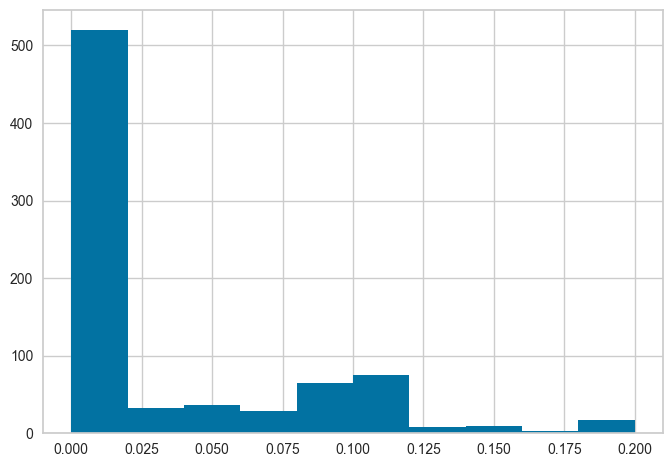

In [470]:
amount_spent_customer = amount_spent_customer.groupby("customer_id").agg(
                                            total_original_price=("total_original_price","sum"),
                                            total_spent=("total_spent","sum"),
                                            median_discount=("discount","median")
                                            )
amount_spent_customer["median_discount"].hist()

##### Option 2 - Correlation of spending with discounts

discount_corr
customer_id               
AA-10315          0.045609
AA-10375         -0.072842
AA-10480          0.130095
AA-10645          0.100239
AB-10015          0.244514

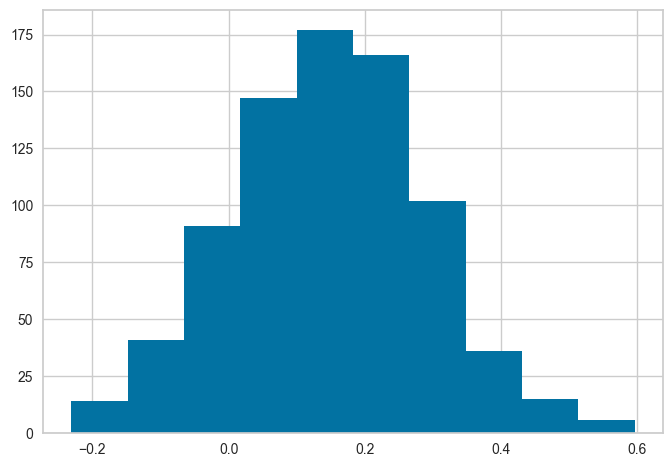

In [471]:
# groupby client and calculate
corr_client = global_superstore.groupby('customer_id').apply(calculate_discount_expense_correlation).reset_index()
corr_client.columns = ['customer_id', 'discount_corr']
corr_client.set_index("customer_id",inplace=True)
corr_client['discount_corr'].hist()
corr_client.head()

<Axes: xlabel='discounted_price', ylabel='sales'>

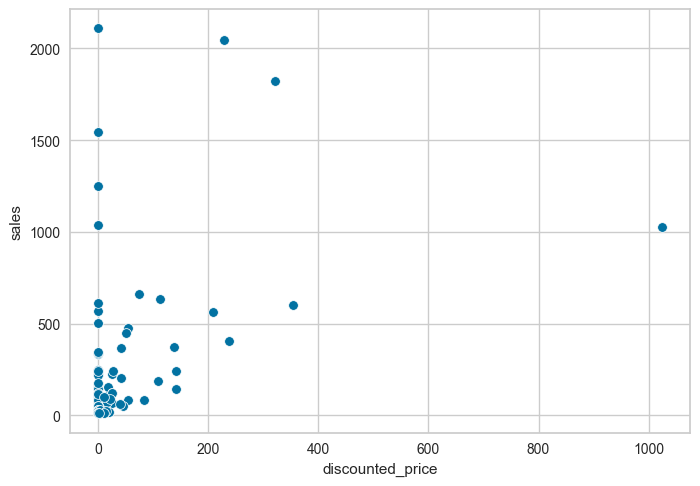

In [472]:
sns.scatterplot(data=global_superstore[global_superstore["customer_id"]=="AB-10015"],
                x="discounted_price",
                y="sales")

#### median quantity per order, median ppu per order

In [473]:
median_q_ppu_discount_order = (global_superstore.groupby(["customer_id", "order_id"]
                    ).agg(
                        total_spending_order=("sales", "sum"),
                        total_quantity=("quantity", "sum"),
                        total_discounted_price=("discounted_price","sum"))
                    .assign(unit_price_order=lambda df: df["total_spending_order"]/df["total_quantity"])
                    .groupby("customer_id")
                    .agg(
                        median_unit_price=("unit_price_order", "median"),
                        median_spending_order=("total_spending_order", "median"),
                        median_quantity_order=("total_quantity","median")))

median_q_ppu_discount_order.head()

median_unit_price  median_spending_order median_quantity_order
customer_id                                                               
AA-10315               46.038                270.600                   4.5
AA-10375            19.373625                 90.480                   4.0
AA-10480                68.07                386.520                   5.0
AA-10645             38.88637                209.760                   6.0
AB-10015                58.32                309.592                   7.0

#### Joining metrics

Version with median spending per order.

In [474]:
customer_aggregated_v1 = pd.concat([median_purchase_freq,median_ticket_order["median_spending_order"],
                                 amount_spent_customer["median_discount"],
                                 corr_client],axis=1)
print(f"The aggregated customer v1 df has {customer_aggregated_v1.shape[0]} rows")
customer_aggregated_v1.head()

The aggregated customer v1 df has 795 rows


median_orders_month  median_spending_order  median_discount  \
customer_id                                                                
AA-10315                     1.0                270.600         0.000000   
AA-10375                     1.0                 90.480         0.024334   
AA-10480                     1.0                386.520         0.100000   
AA-10645                     1.0                209.760         0.000000   
AB-10015                     1.0                309.592         0.000000   

             discount_corr  
customer_id                 
AA-10315          0.045609  
AA-10375         -0.072842  
AA-10480          0.130095  
AA-10645          0.100239  
AB-10015          0.244514

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

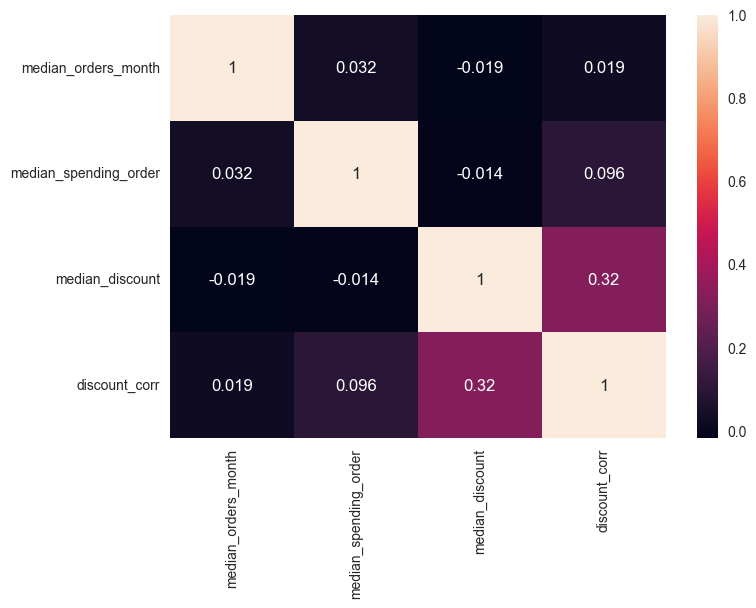

In [475]:
sns.heatmap(customer_aggregated_v1.corr(),annot=True)

Median_shipping_cost and median_spending_order are highly correlated. Hence, median_shipping_cost must be dropped:

In [476]:
customer_aggregated_v1.drop(columns="median_shipping_cost", inplace=True,errors="ignore")

Version with median ppu price and median quantity.

In [477]:
customer_aggregated_v2 = pd.concat([median_purchase_freq,
                                    median_q_ppu_discount_order[["median_unit_price","median_quantity_order"]],
                                 amount_spent_customer["median_discount"],
                                 corr_client],axis=1)
print(f"The aggregated customer v2 df has {customer_aggregated_v2.shape[0]} rows")
customer_aggregated_v2.head()

The aggregated customer v2 df has 795 rows


median_orders_month median_unit_price median_quantity_order  \
customer_id                                                                
AA-10315                     1.0            46.038                   4.5   
AA-10375                     1.0         19.373625                   4.0   
AA-10480                     1.0             68.07                   5.0   
AA-10645                     1.0          38.88637                   6.0   
AB-10015                     1.0             58.32                   7.0   

             median_discount  discount_corr  
customer_id                                  
AA-10315            0.000000       0.045609  
AA-10375            0.024334      -0.072842  
AA-10480            0.100000       0.130095  
AA-10645            0.000000       0.100239  
AB-10015            0.000000       0.244514

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

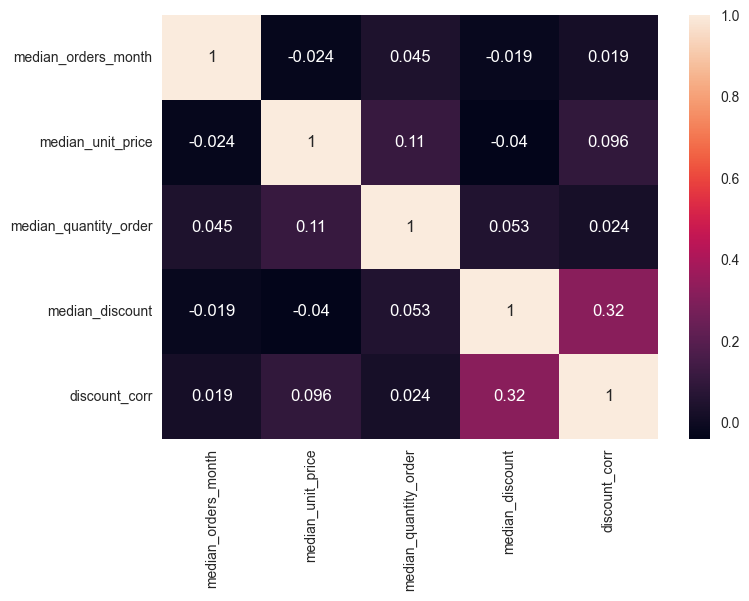

In [478]:
sns.heatmap(customer_aggregated_v2.corr(),annot=True)

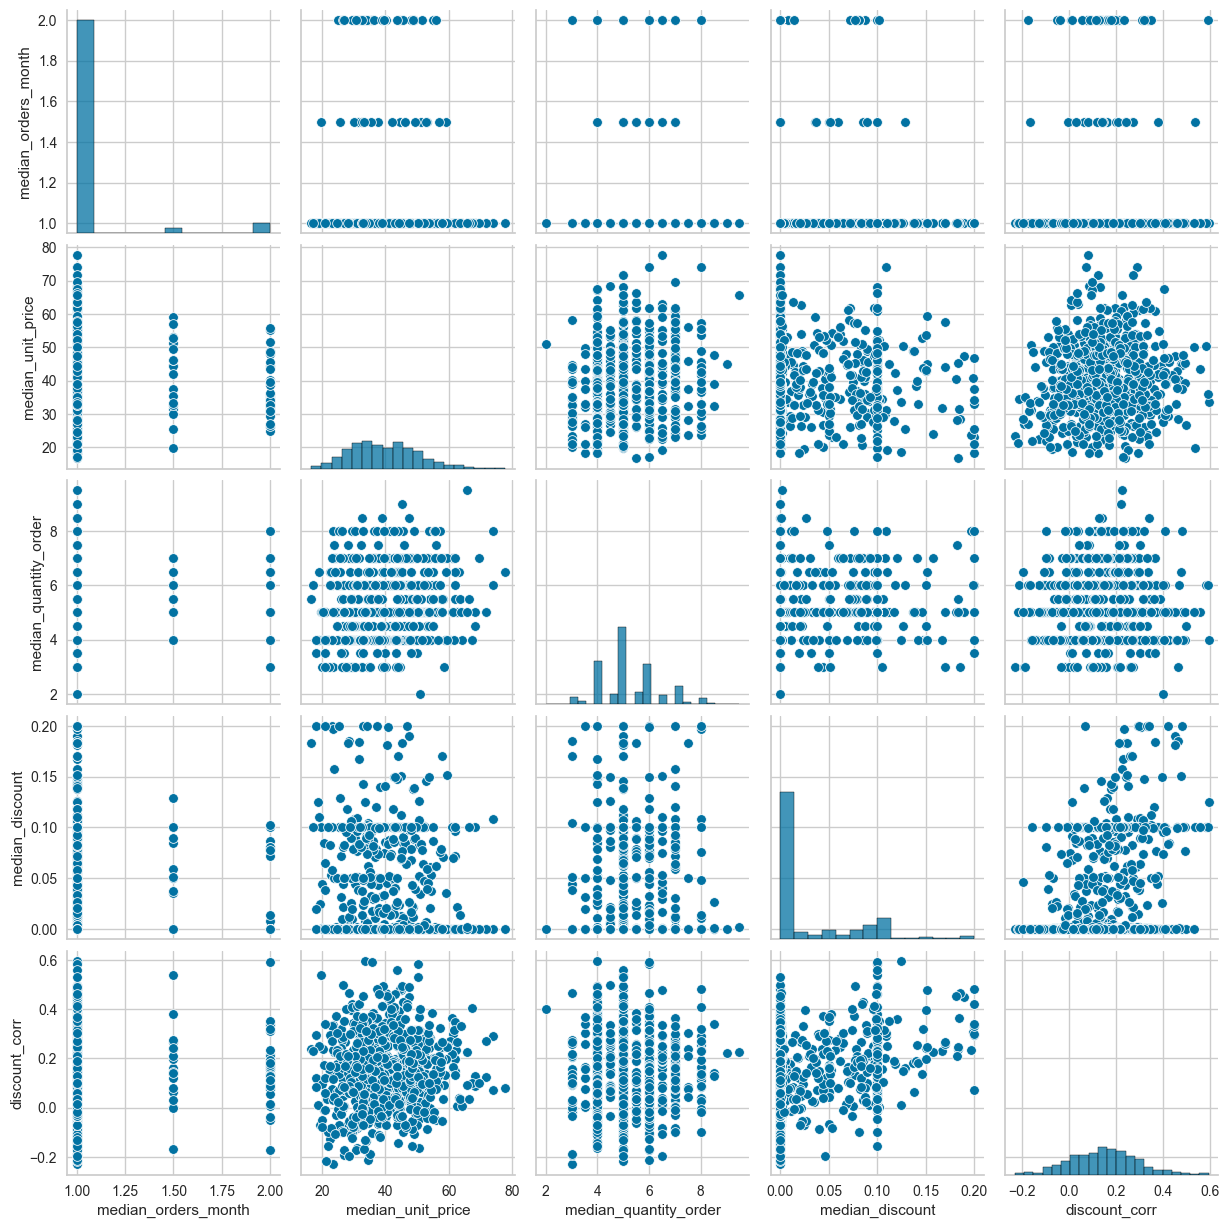

In [479]:
sns.pairplot(customer_aggregated_v2)

## 2.3 Preprocessing

Preprocessing should include categorical encoding, outlier handling and feature scaling. As for this iteration only numerical features are included, only feature scaling and outlier handling are needed.

#### Outlier handling

Contamination set to 2%.

Handle customer_aggregated_v1 first, then v2.

In [623]:
seed=42

In [636]:
# detect v1
gestor_outliers = so.GestionOutliersMultivariados(customer_aggregated_v1)

customer_aggregated_v1_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.03, random_state=seed).replace({"outlier":{1:0,-1:1}})


# detect v2
gestor_outliers = so.GestionOutliersMultivariados(customer_aggregated_v2)

customer_aggregated_v2_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.03, random_state=seed).replace({"outlier":{1:0,-1:1}})

Inspecting the results via pairplots:

Pairplot of version 1


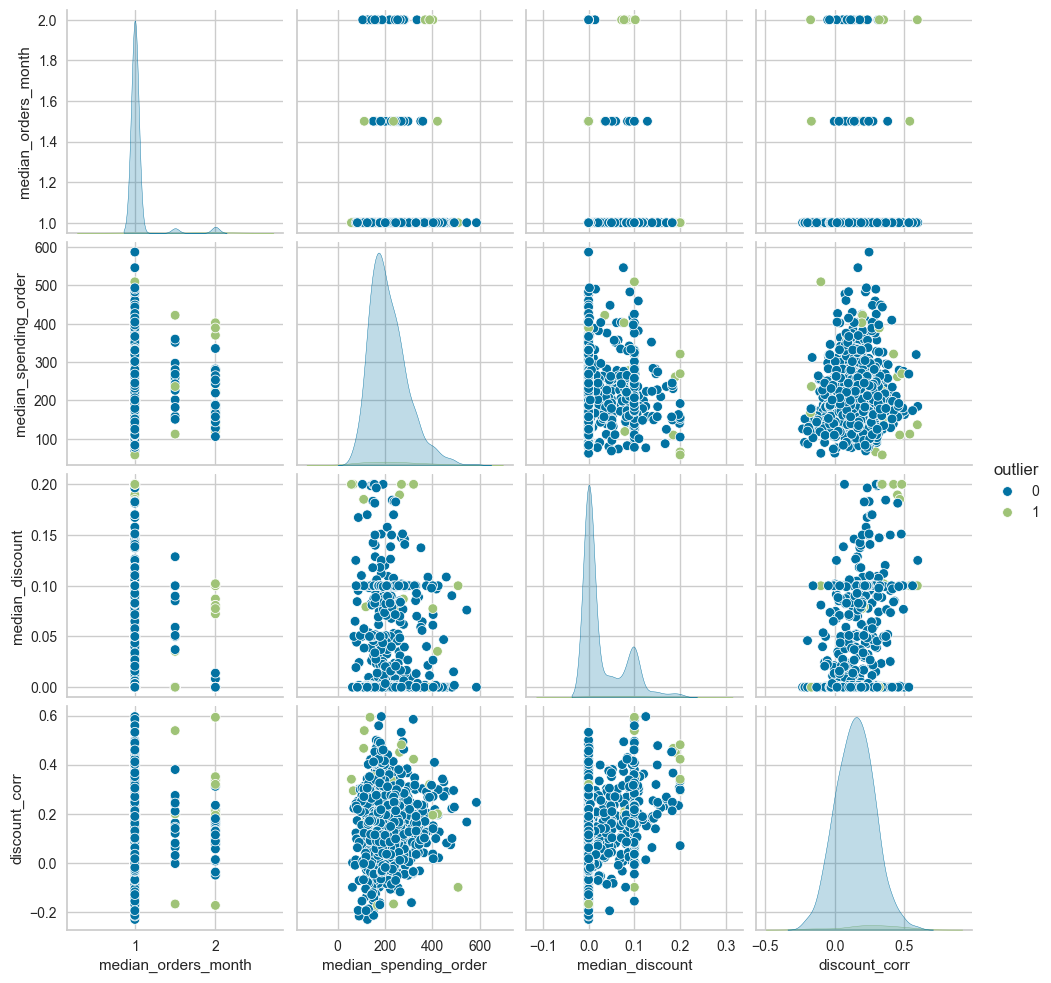



Pairplot of version 2


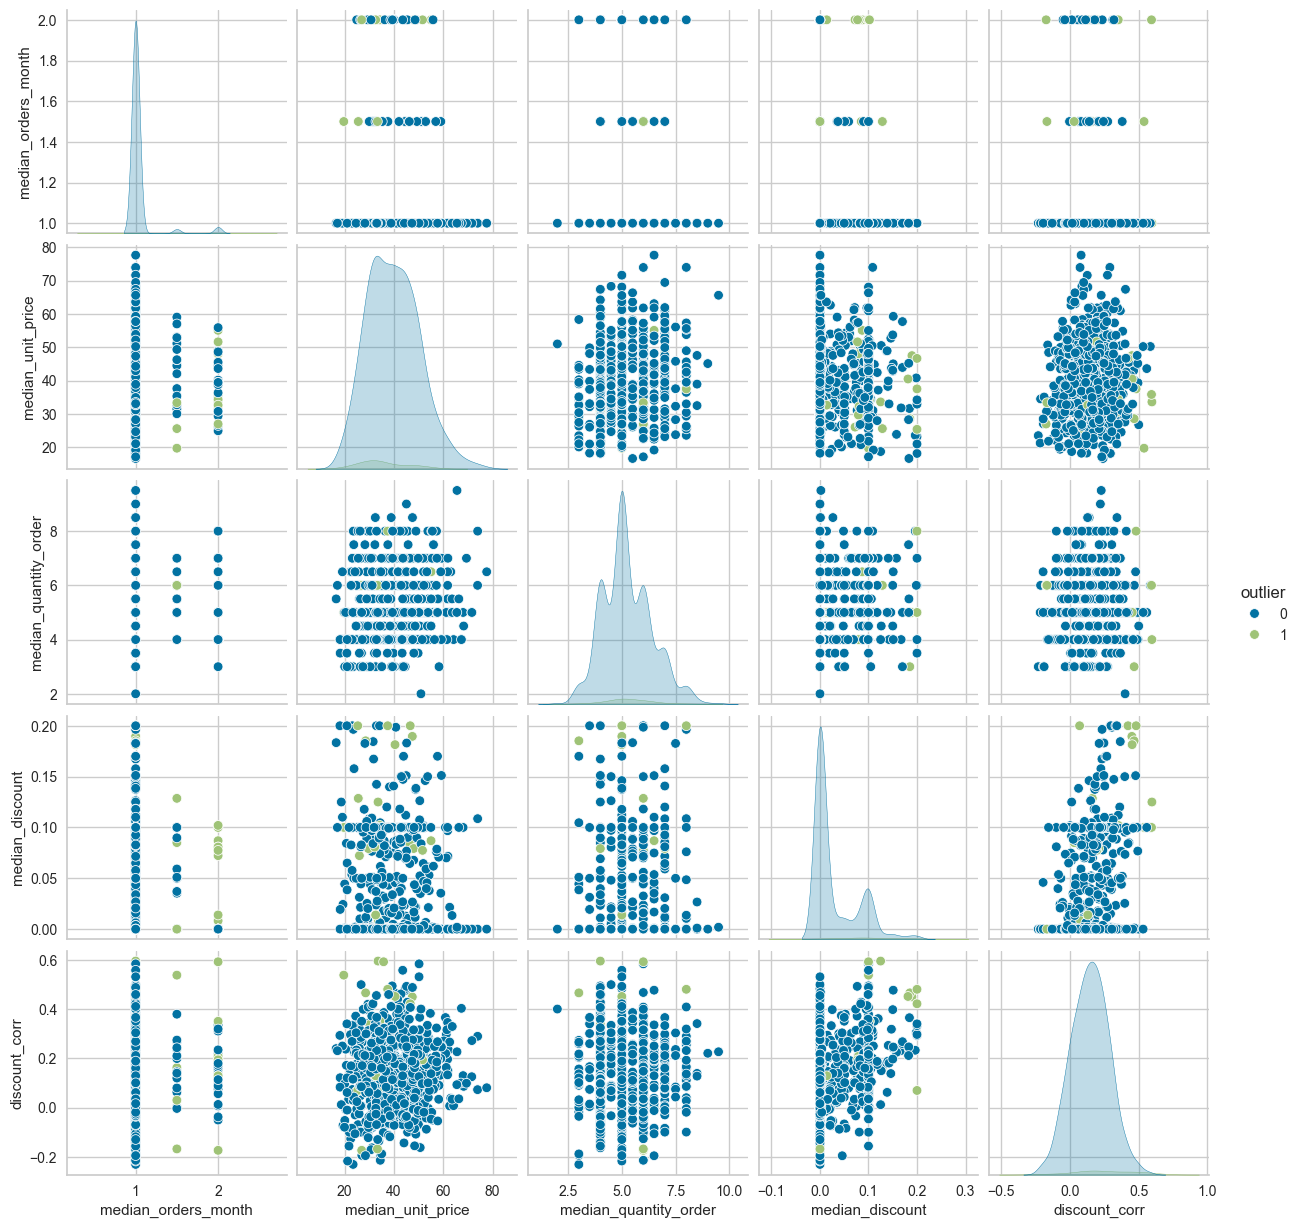

In [637]:
print("Pairplot of version 1") # cannot use titles apparently
sns.pairplot(customer_aggregated_v1_outliers, hue="outlier")
plt.show()

print("\n\nPairplot of version 2")
sns.pairplot(customer_aggregated_v2_outliers, hue="outlier")
plt.show()

Outliers detected visually look correct. To not introduce noise into the model, these records are better left out of the clustering process. Therefore:

In [638]:
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers[customer_aggregated_v1_outliers["outlier"]==0].drop(columns="outlier")

customer_aggregated_v2_outliers = customer_aggregated_v2_outliers[customer_aggregated_v2_outliers["outlier"]==0].drop(columns="outlier")

##### Feature scaling

To retain the maximum information possible about distances, we use robust scaling.

In [639]:
scaler = RobustScaler()

customer_aggregated_v1_scaled = pd.DataFrame(scaler.fit_transform(customer_aggregated_v1_outliers),
                                             columns=customer_aggregated_v1_outliers.columns)
customer_aggregated_v1_scaled

customer_aggregated_v2_scaled = pd.DataFrame(scaler.fit_transform(customer_aggregated_v2_outliers),
                                             columns=customer_aggregated_v2_outliers.columns)
customer_aggregated_v2_scaled

median_orders_month  median_unit_price  median_quantity_order  \
0                    0.0           0.457753              -0.333333   
1                    0.0          -1.273300              -0.666667   
2                    0.0           1.888073               0.000000   
3                    0.0          -0.006531               0.666667   
4                    0.0           1.255102               1.333333   
..                   ...                ...                    ...   
766                  0.0          -0.929849              -0.333333   
767                  0.0           0.728276               0.000000   
768                  0.0           0.343622               0.000000   
769                  0.0          -0.696623               1.666667   
770                  0.0           0.540981               0.000000   

     median_discount  discount_corr  
0           0.000000      -0.520573  
1           0.461816      -1.135619  
2           1.897796      -0.081890  
3           0.000000      -0.236913  
4           0.000000       0.512221  
..               ...            ...  
766         0.000000       0.823558  
767         0.000000       2.005726  
768         0.000000      -0.672641  
769         3.465792       0.342368  
770         0.000000       0.224460  

[771 rows x 5 columns]

#### Visualize results

To get an intuition for the separability of the data, let's plot the pairplots for the scaled data.

Version 1 of customer aggregated data:

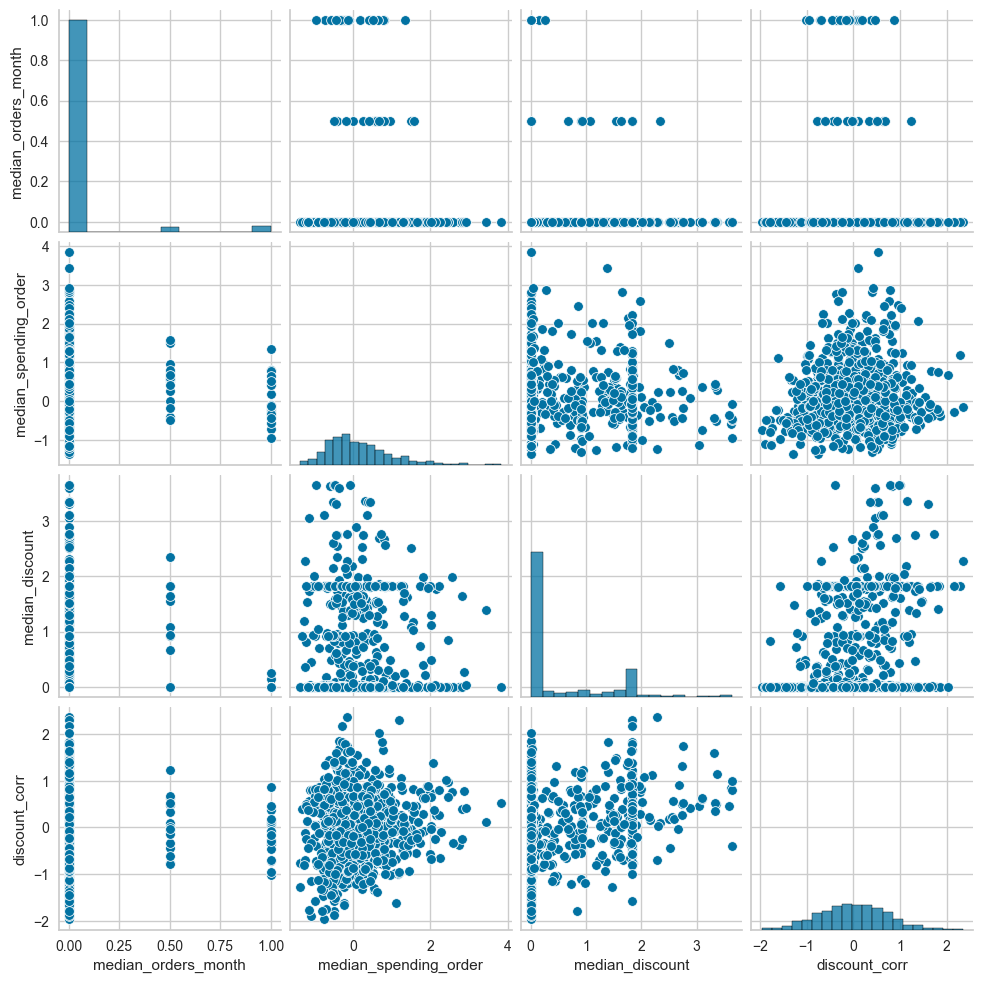

In [640]:
sns.pairplot(customer_aggregated_v1_scaled)

Version 2 of customer aggregated data:

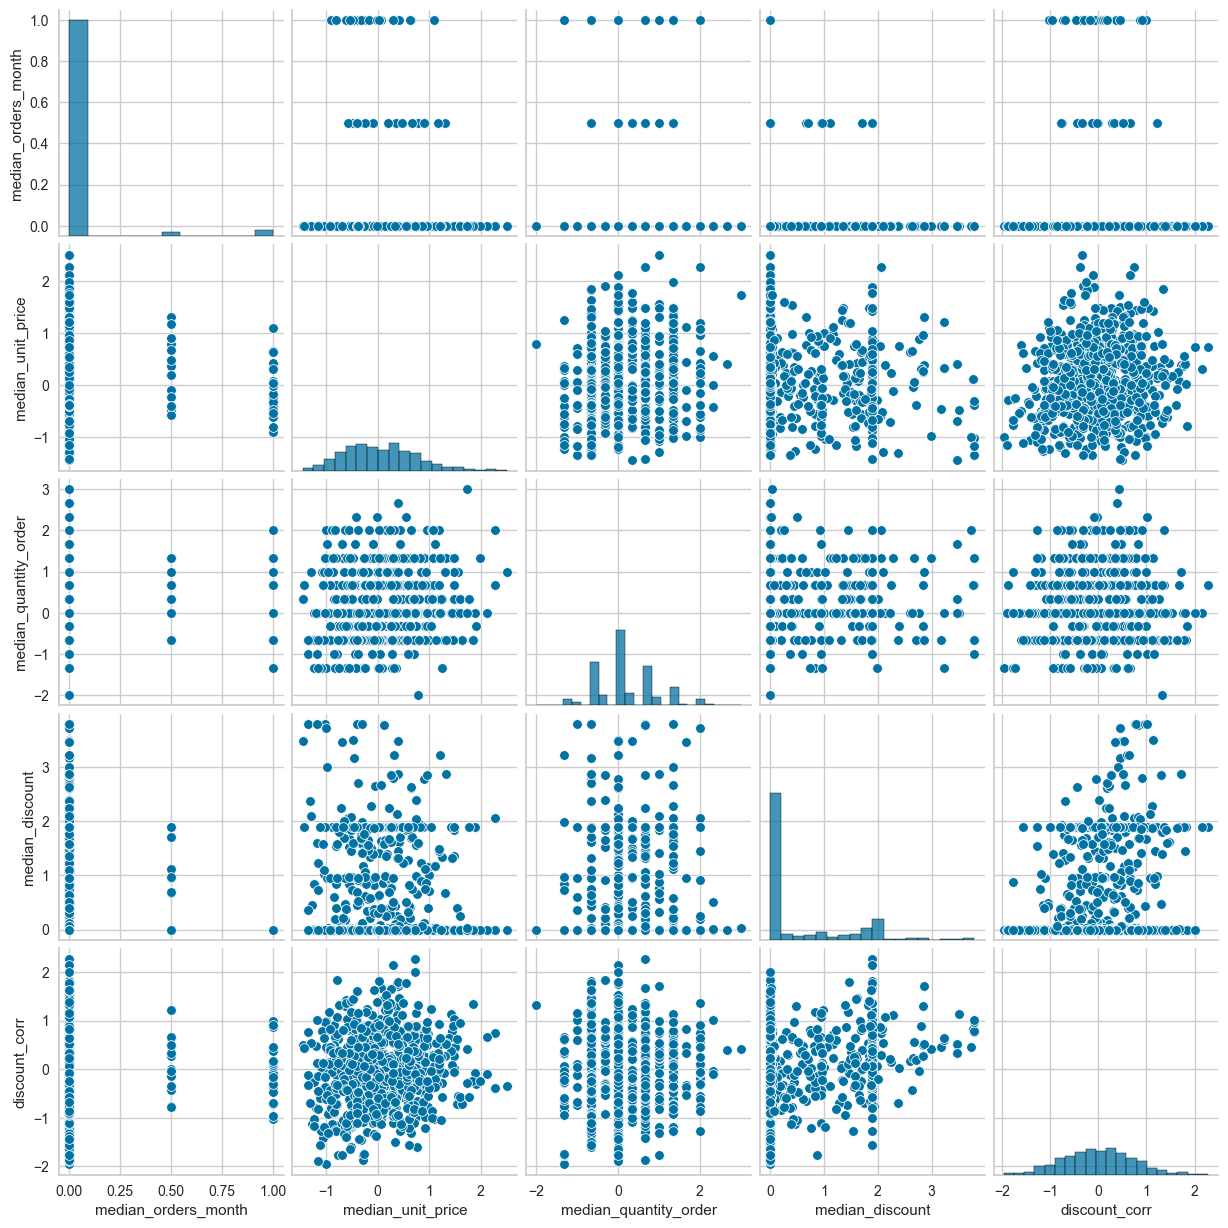

In [641]:
sns.pairplot(customer_aggregated_v2_scaled)

### Dimensionality reduction

The above pairplots do not show a single pairwise relationship that looks separable. There is a method for dimensionality reduction called t-SNE that helps visualize if data is separable even in a high dimensional space.

#### t-SNE

Applying t-SNE for version 1:

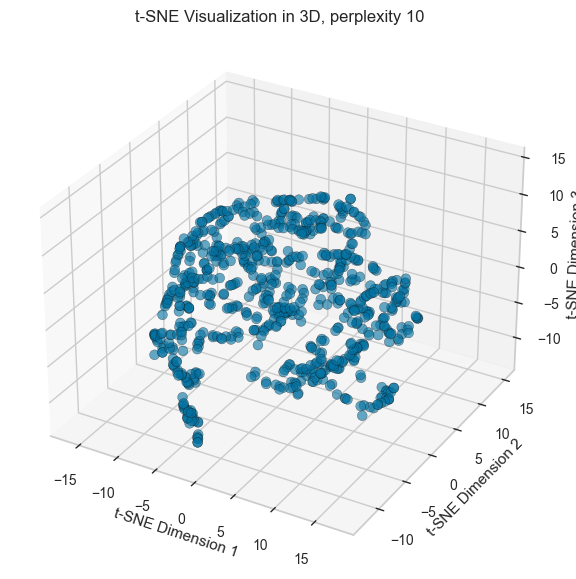

In [642]:
t_sne(customer_aggregated_v1_scaled,dim=3,perplexity=10)

Applying t-SNE for version 2:

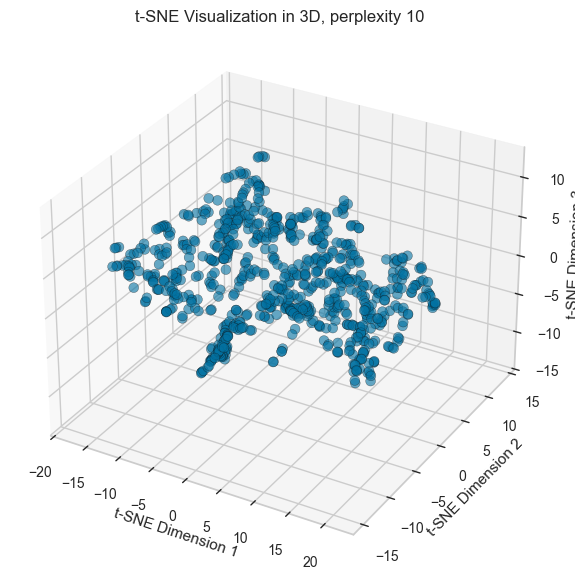

In [643]:
t_sne(customer_aggregated_v2_scaled,dim=3,perplexity=10)

t-SNE does not show clearly separable clusters either, although the results depend highly on the perplexity parameter. 

There is another dimensionality reduction technique worth trying, PCA.

#### Principal Component Analysis (PCA)

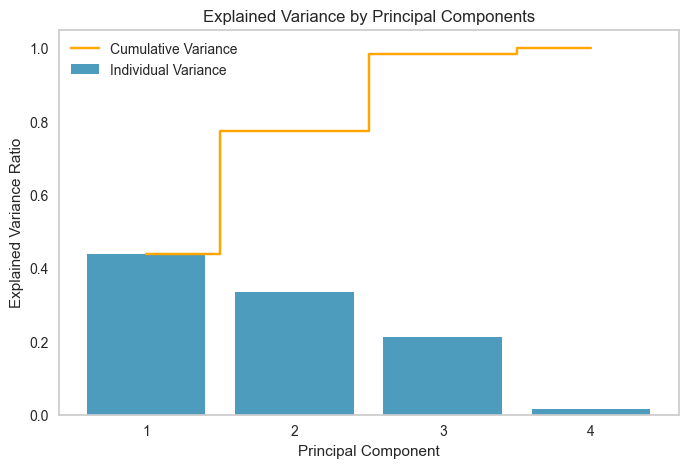

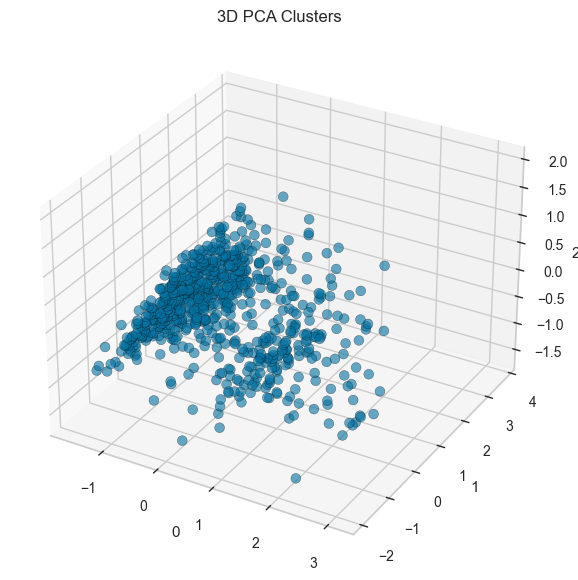

In [644]:
X_pca_v1 = perform_PCA(customer_aggregated_v1_scaled)
plot_3D_clusters(X_pca_v1)

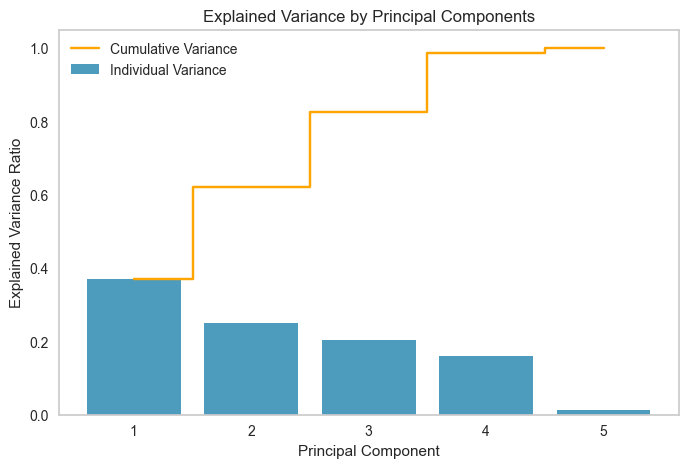

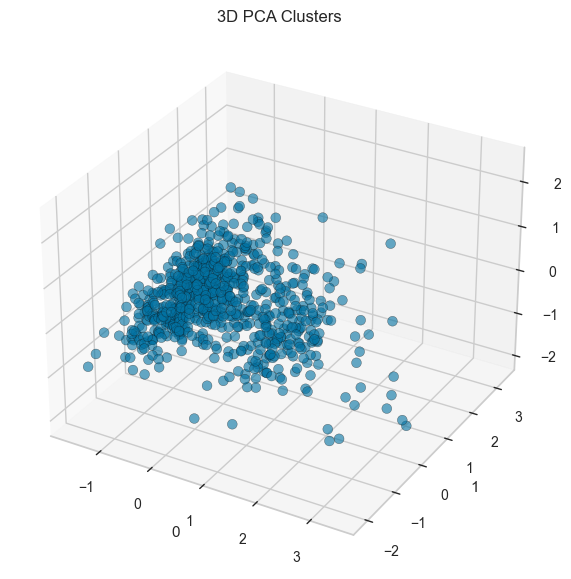

In [645]:
X_pca_v2 = perform_PCA(customer_aggregated_v2_scaled)
plot_3D_clusters(X_pca_v2)

PCA does not look like it does a great job separating features either. Besides, its best use is to reduce dimensions while retaining the most variance. In this case, the suggested subsets only have 5 and 6 features, and PCA does not achieve a good enough compression. Therefore, it will be left for later when encoded categorical features are introduced into the model.

# 2.4 Clustering

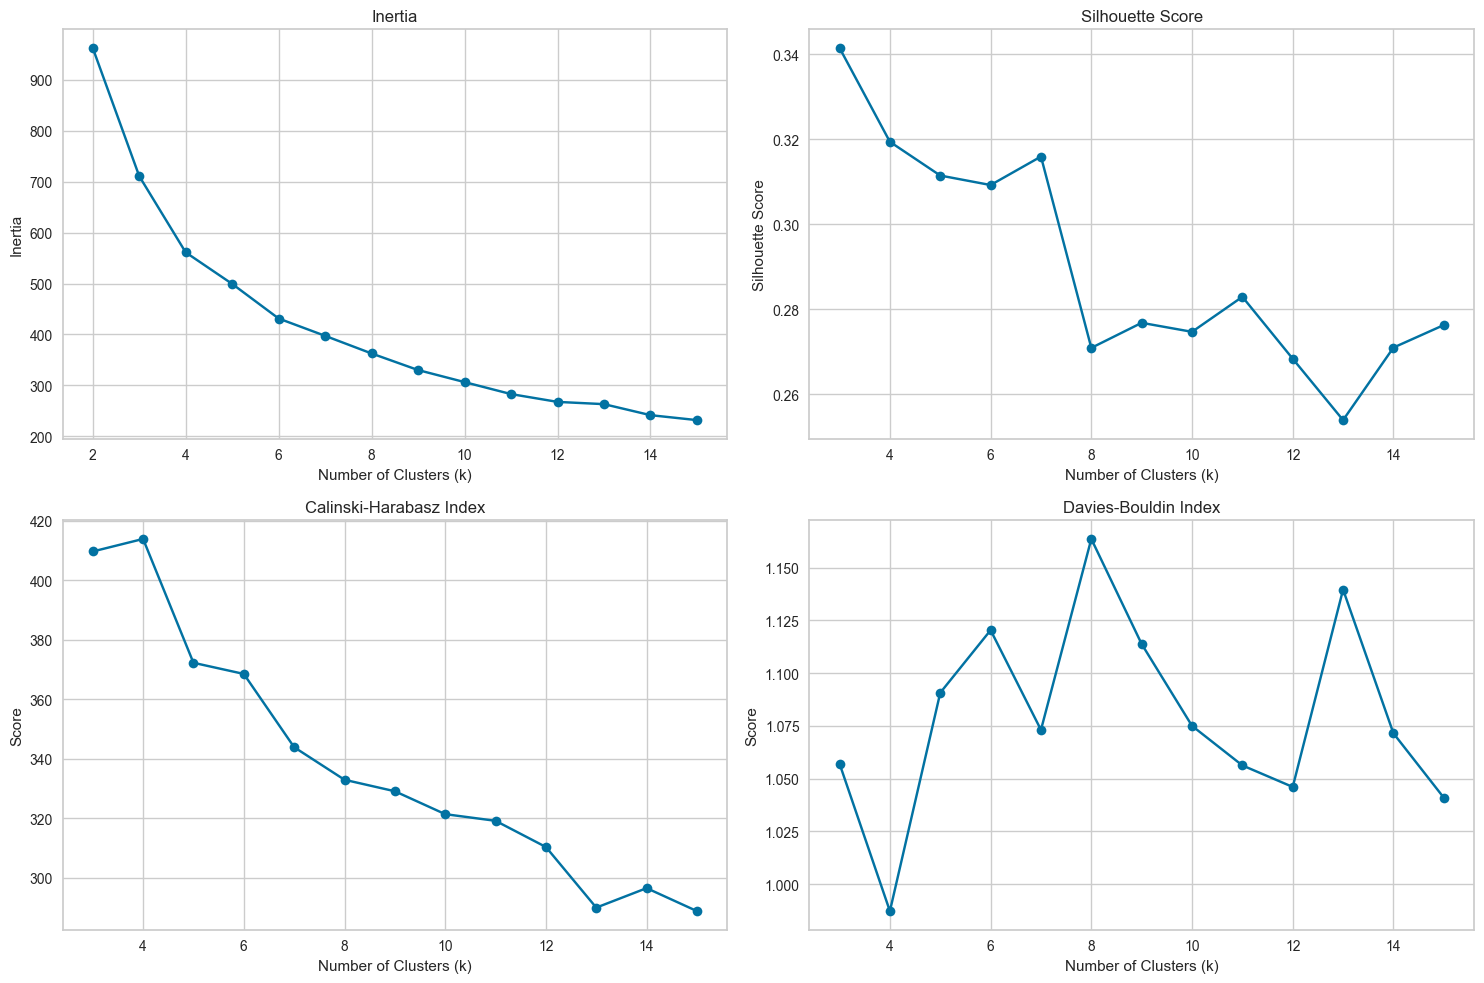

In [646]:
choose_kmeans_k(customer_aggregated_v1_scaled, random_state=seed)

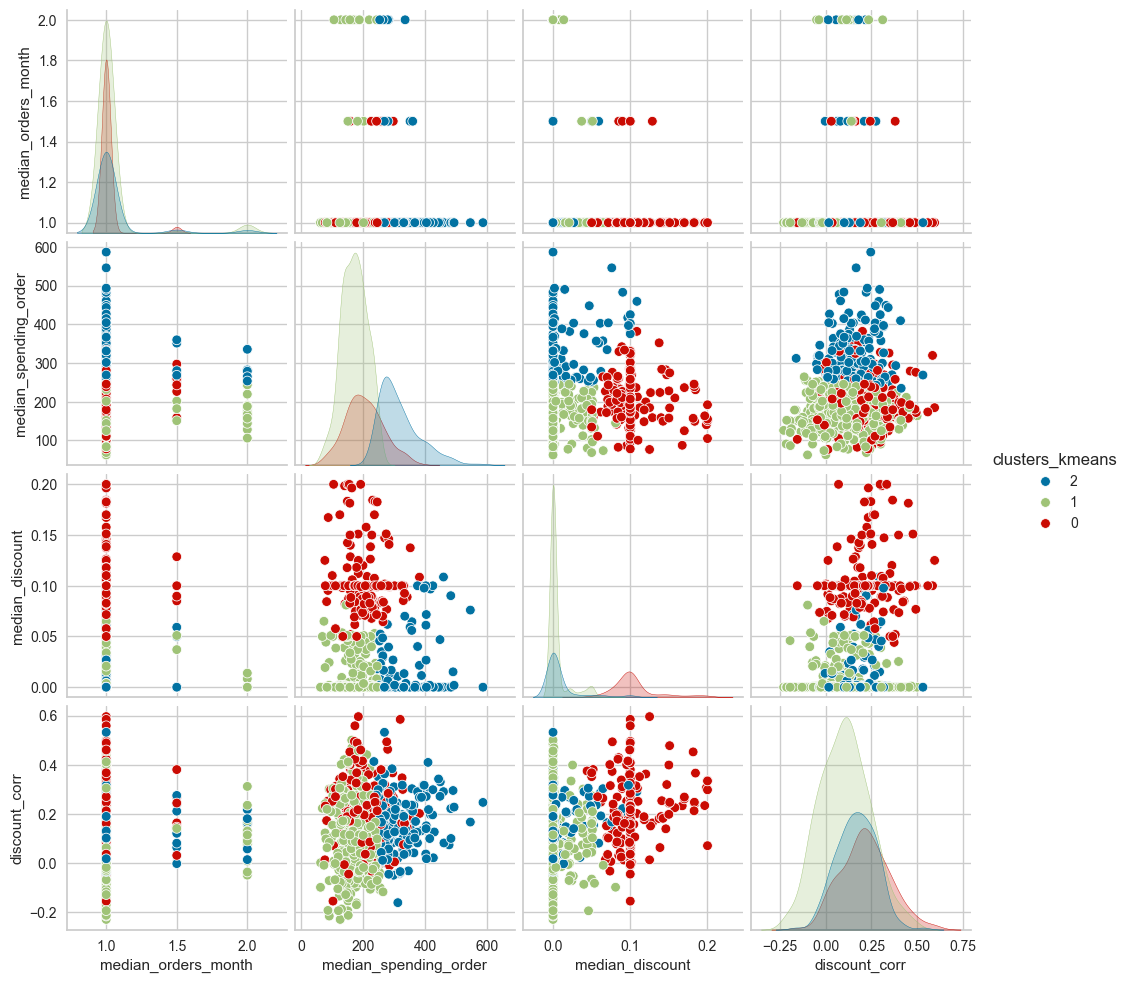

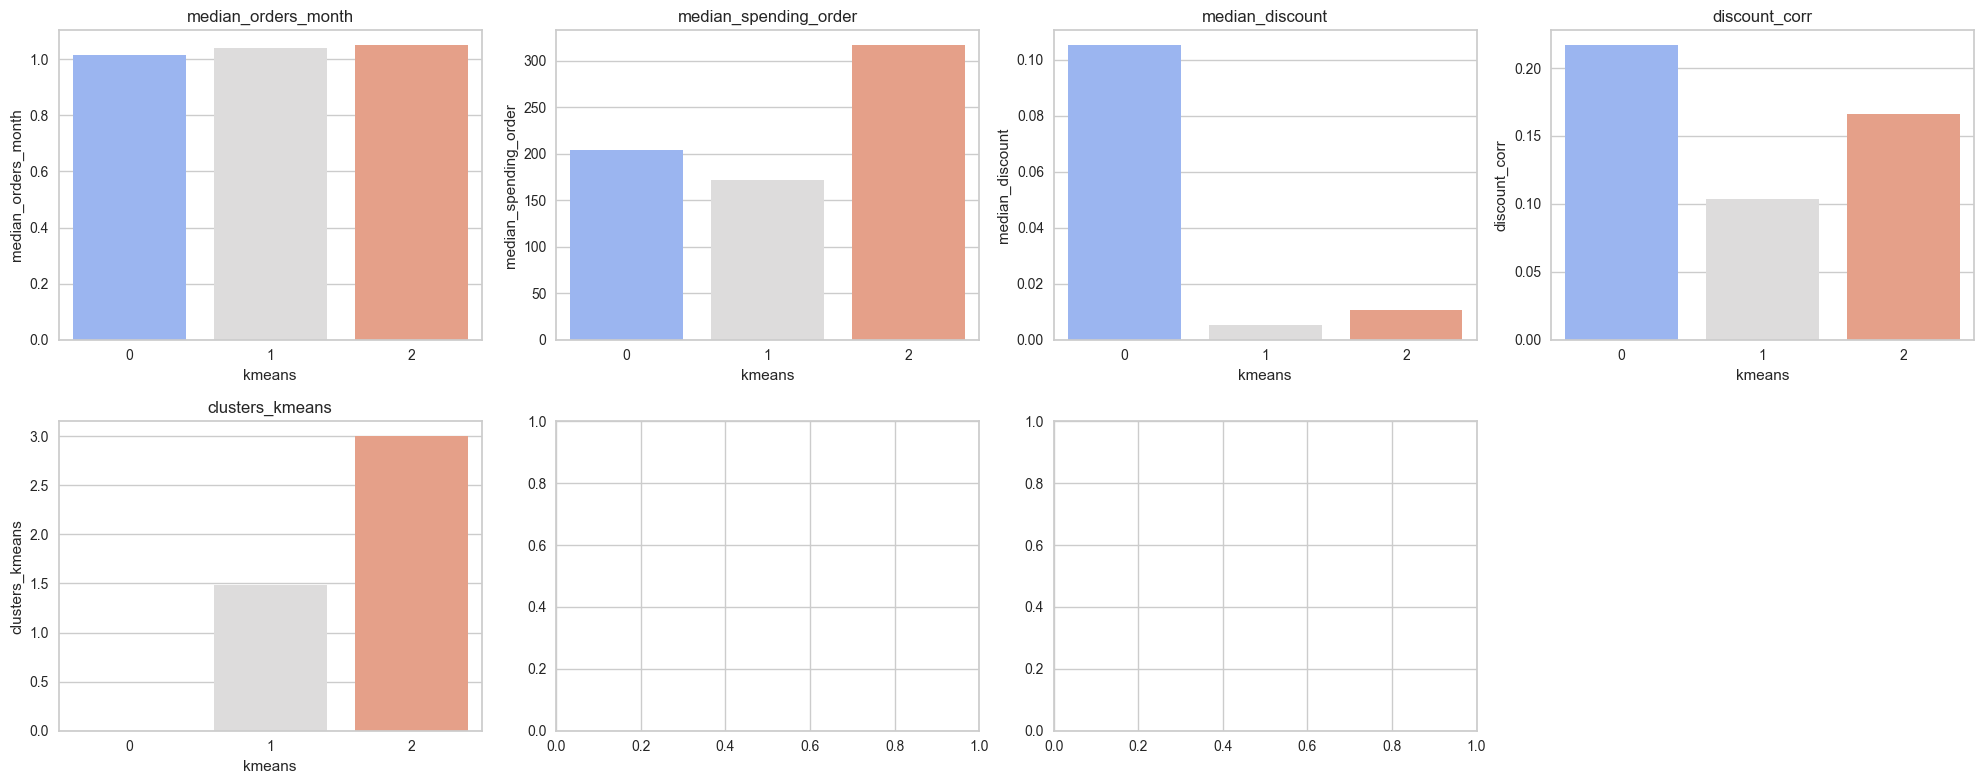

In [651]:
warnings.filterwarnings("ignore")
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers.astype("float")
clusterizador_v1 = sc.Clustering(customer_aggregated_v1_outliers)

# 
clusterizador_v1.preparar_dataframe(scaler="robust")

customer_aggregated_v1_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,3, random_state=seed)

sns.pairplot(customer_aggregated_v1_clustered, hue="clusters_kmeans")

clusterizador_v1.plot_clusters("kmeans")
warnings.filterwarnings("default")

In [652]:
clusterizador_v1.calcular_metricas("kmeans")
print("Clustering cardinality:")
customer_aggregated_v1_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0    179
1    404
2    188
dtype: int64

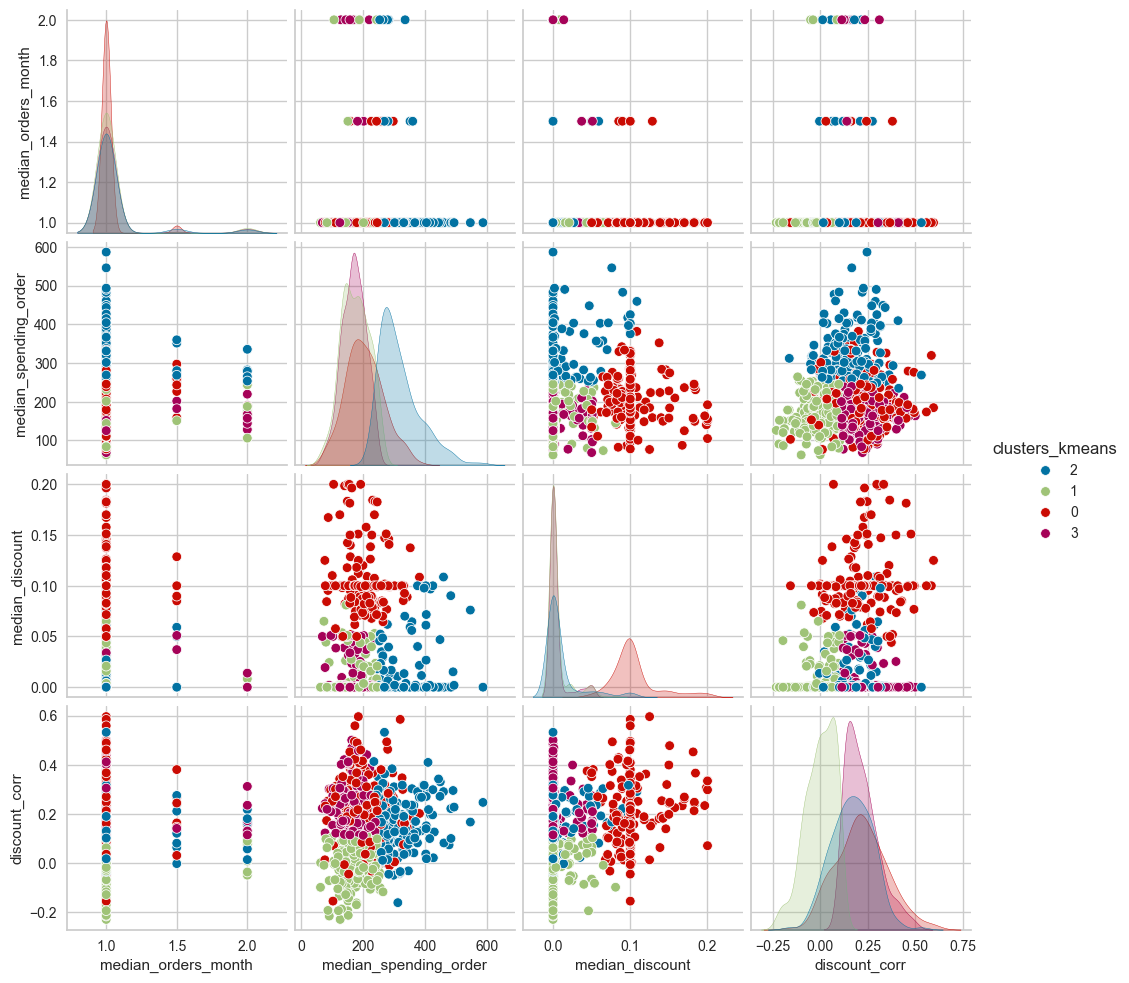

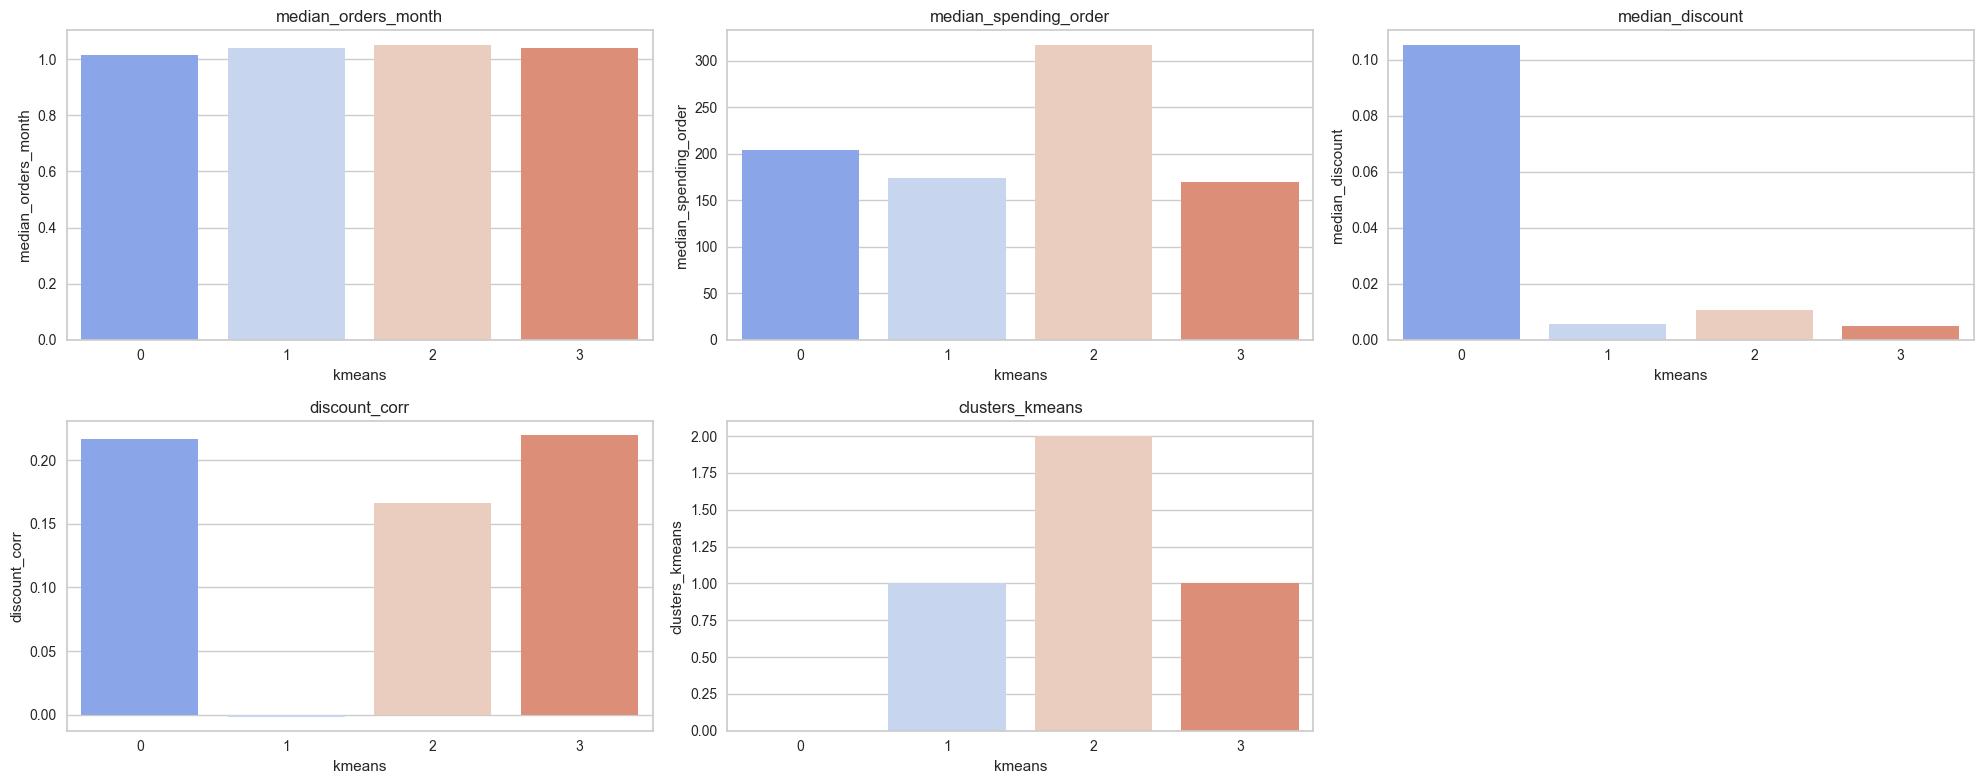

In [653]:
warnings.filterwarnings("ignore")
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers.astype("float")
clusterizador_v1 = sc.Clustering(customer_aggregated_v1_outliers)

# 
clusterizador_v1.preparar_dataframe(scaler="robust")

customer_aggregated_v1_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,4,random_state=seed)

sns.pairplot(customer_aggregated_v1_clustered, hue="clusters_kmeans")

clusterizador_v1.plot_clusters("kmeans")

warnings.filterwarnings("default")

In [654]:
clusterizador_v1.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0            0.3681              0.913827           179

In [655]:
print("Clustering cardinality:")
customer_aggregated_v1_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0    179
1    212
2    188
3    192
dtype: int64

In [663]:
path_dir = "../data/clusters"
os.makedirs(path_dir,exist_ok=True)
customer_aggregated_v1_clustered.to_pickle(f"{path_dir}/customer_aggregated_v1_k4.pkl")

In [658]:
saved_labels = clusterizador_v1.labels["kmeans"]
saved_labels

array([2, 1, 2, 1, 2, 1, 0, 3, 3, 3, 2, 1, 2, 3, 3, 3, 3, 0, 1, 2, 0, 1,
       0, 0, 1, 0, 2, 2, 0, 3, 2, 3, 1, 1, 3, 1, 2, 1, 1, 3, 2, 2, 1, 2,
       2, 3, 1, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 3, 0, 2,
       3, 3, 3, 2, 3, 1, 2, 0, 2, 3, 2, 2, 0, 3, 3, 2, 0, 2, 1, 0, 1, 0,
       1, 0, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 3, 0, 3, 2, 2, 1, 1,
       1, 0, 3, 3, 1, 0, 0, 0, 0, 3, 0, 2, 3, 3, 1, 3, 1, 3, 3, 1, 2, 2,
       0, 1, 0, 3, 3, 2, 3, 0, 2, 0, 0, 0, 3, 3, 3, 3, 3, 2, 0, 1, 1, 2,
       2, 2, 3, 2, 3, 3, 1, 2, 2, 1, 3, 0, 1, 1, 3, 2, 2, 1, 3, 2, 2, 2,
       3, 2, 3, 2, 2, 3, 2, 2, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 3, 2, 1,
       3, 0, 2, 2, 1, 2, 2, 1, 0, 2, 2, 3, 1, 2, 0, 1, 2, 3, 2, 0, 0, 0,
       2, 2, 1, 0, 0, 0, 3, 2, 0, 1, 3, 0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 1,
       2, 1, 1, 0, 1, 1, 1, 3, 0, 1, 1, 3, 0, 2, 1, 2, 3, 1, 3, 0, 2, 1,
       2, 1, 3, 0, 3, 3, 1, 0, 0, 1, 0, 3, 3, 3, 3, 0, 1, 0, 1, 3, 3, 0,
       3, 1, 0, 0, 3, 2, 2, 1, 2, 3, 2, 1, 0, 3, 1,

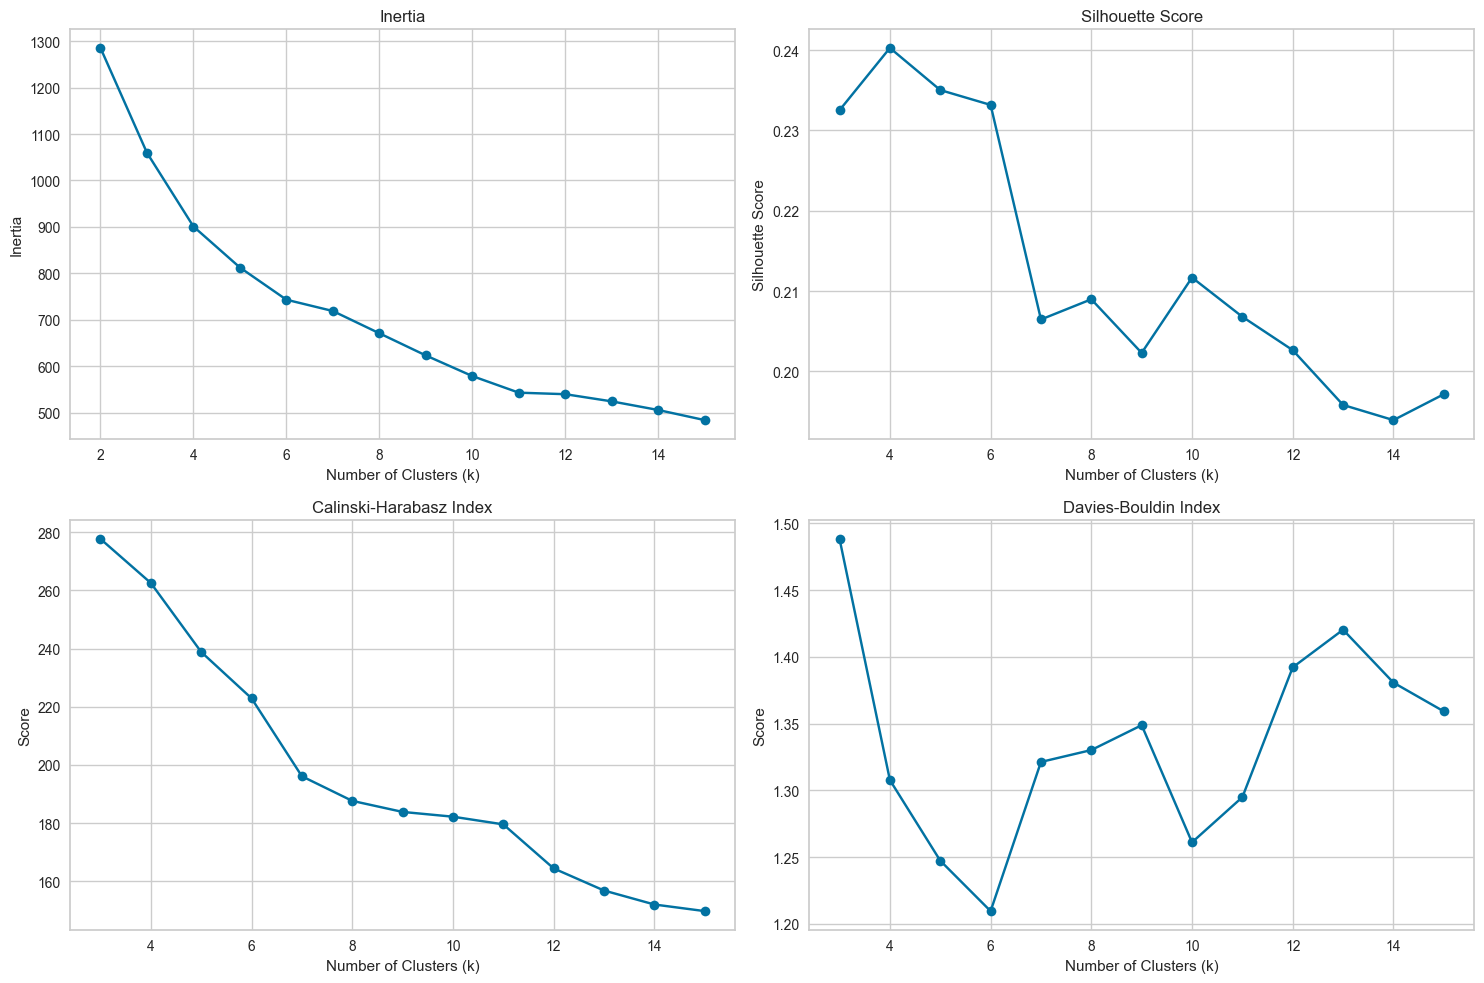

In [660]:
choose_kmeans_k(customer_aggregated_v2_scaled)

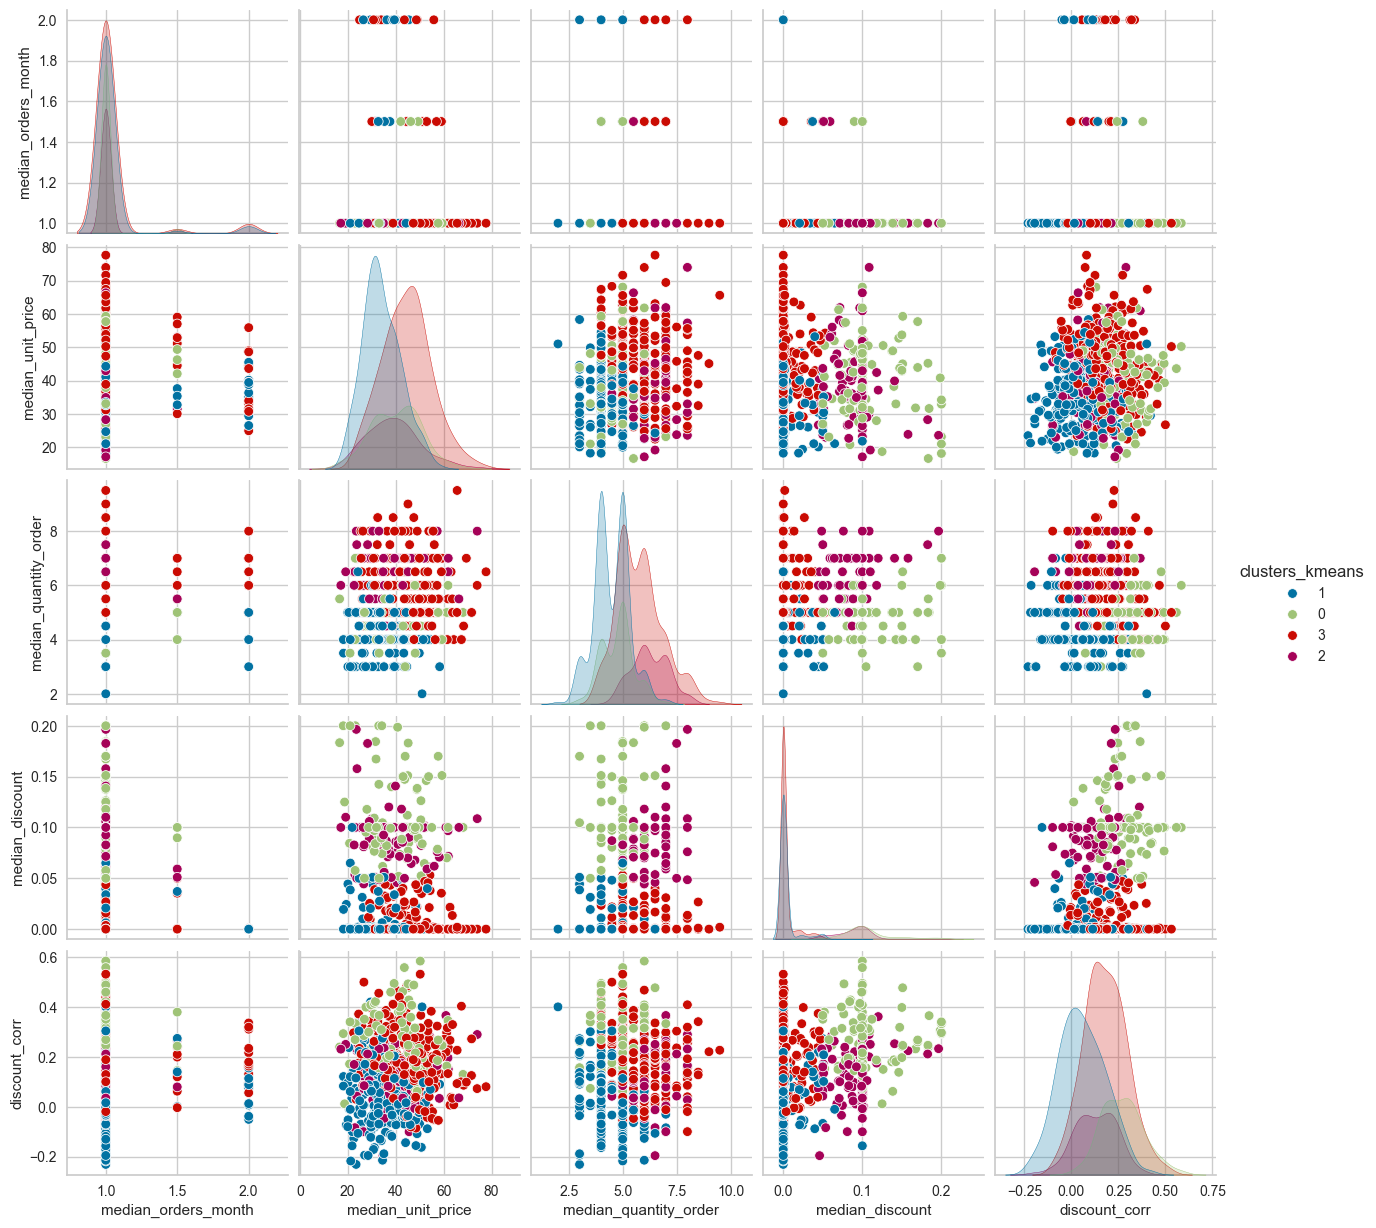

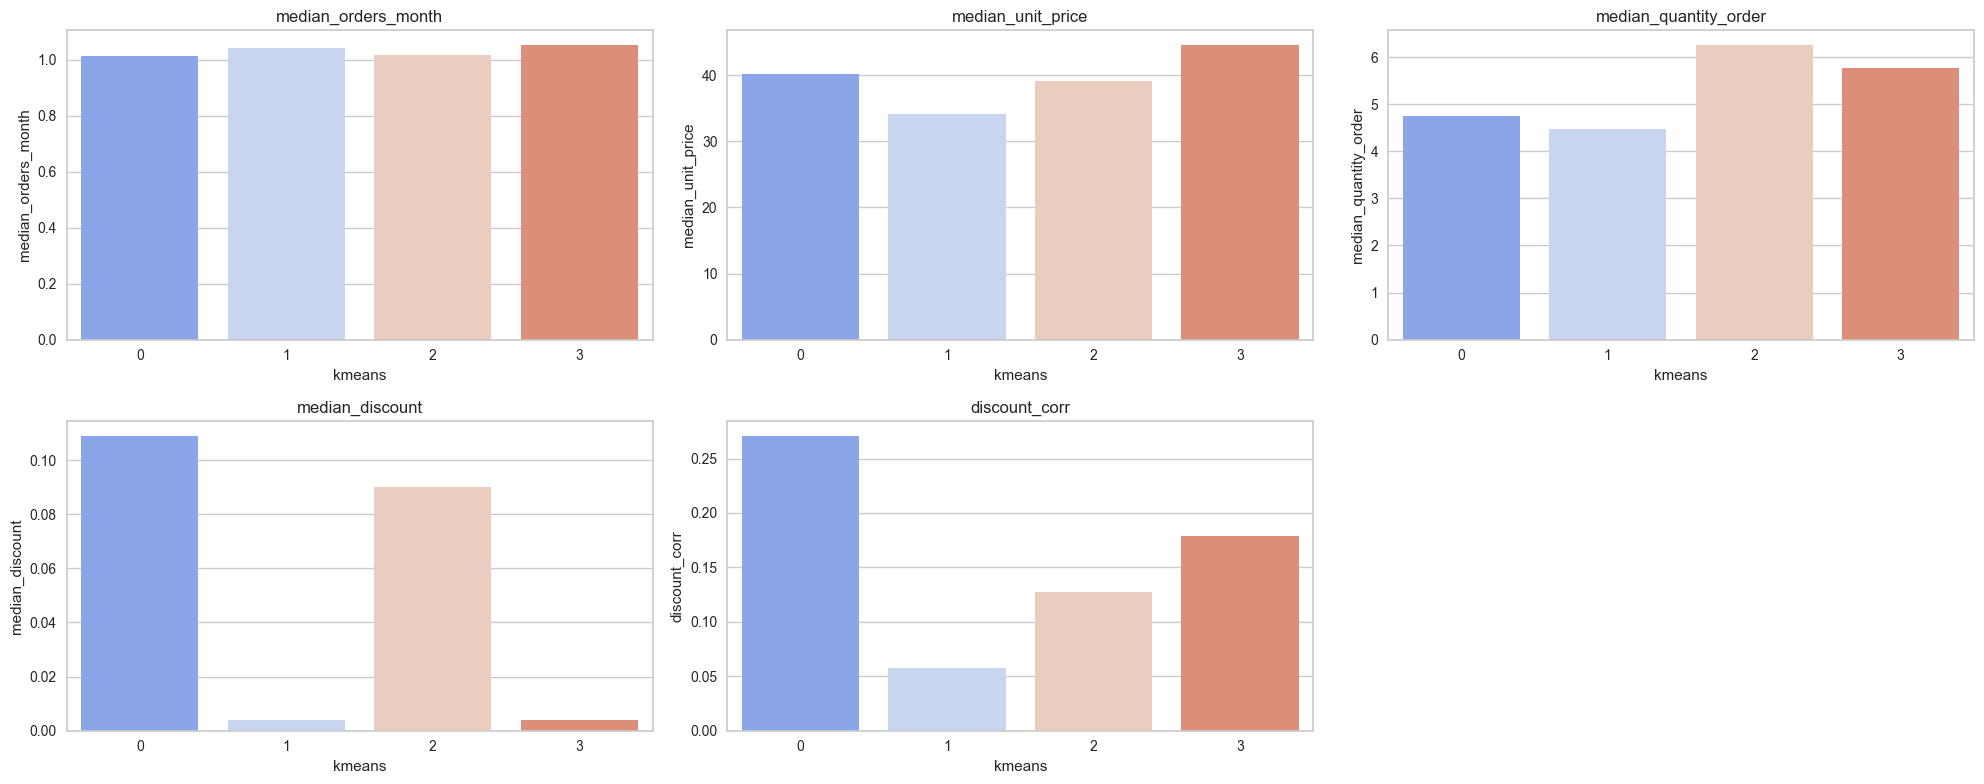

In [661]:
warnings.filterwarnings("ignore")
customer_aggregated_v2_outliers = customer_aggregated_v2_outliers.astype("float")
clusterizador_v2 = sc.Clustering(customer_aggregated_v2_outliers)

# 
clusterizador_v2.preparar_dataframe(scaler="robust")

customer_aggregated_v2_clustered = clusterizador_v2.modelo_kmeans(customer_aggregated_v2_outliers,4)

sns.pairplot(customer_aggregated_v2_clustered, hue="clusters_kmeans")

clusterizador_v2.plot_clusters("kmeans")
warnings.filterwarnings("default")

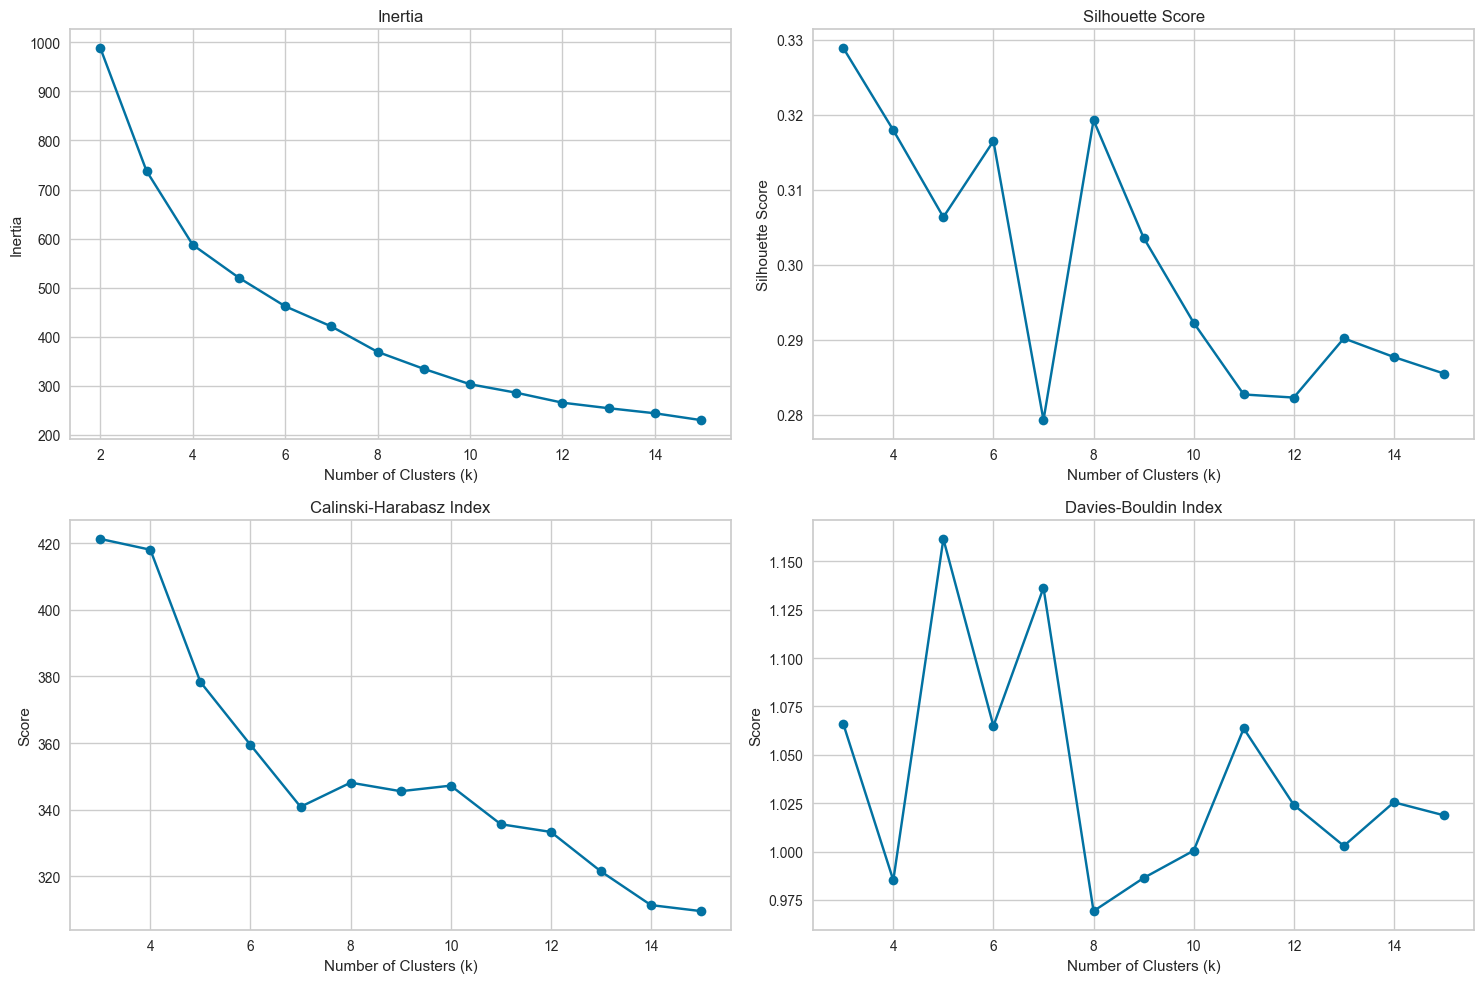

In [306]:
choose_kmeans_k(X_pca_v1)

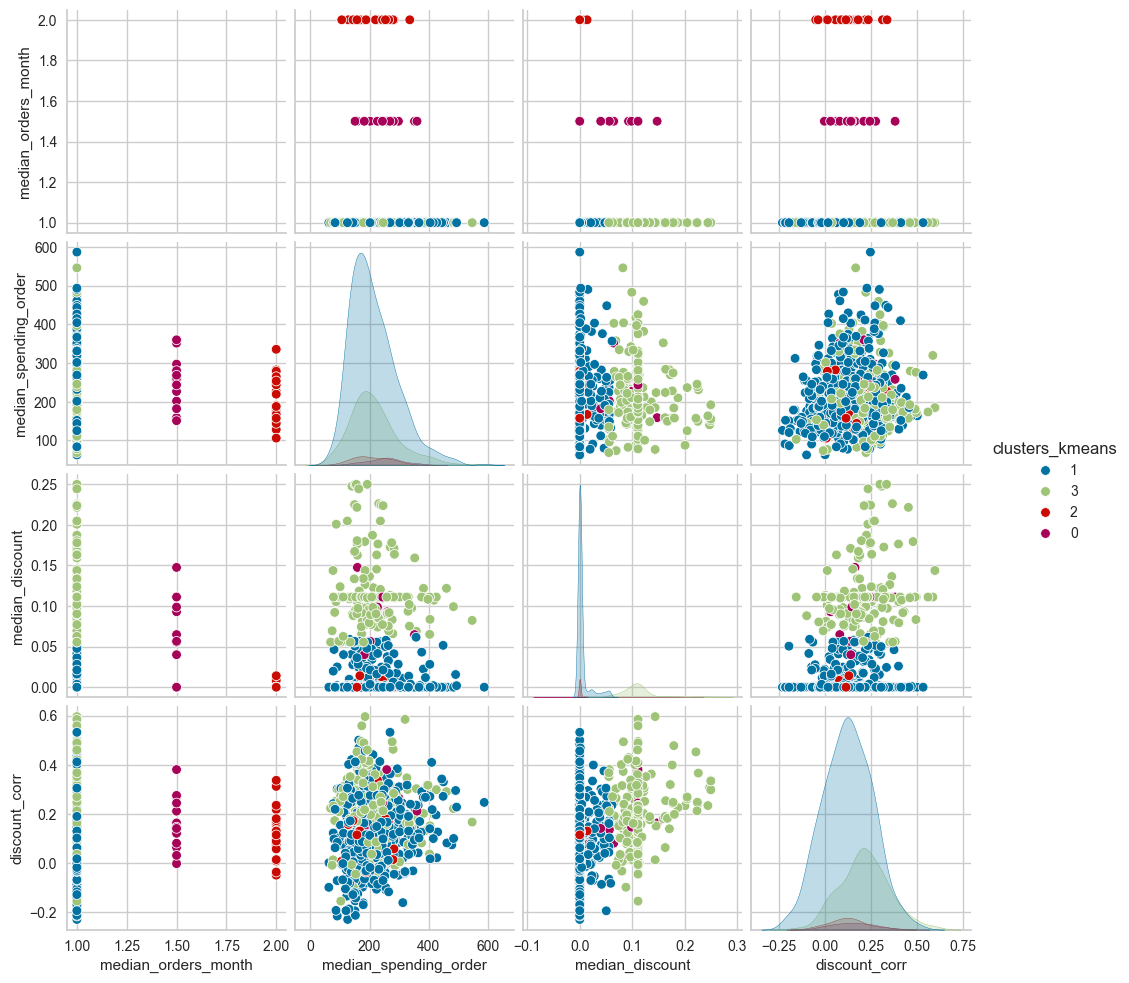

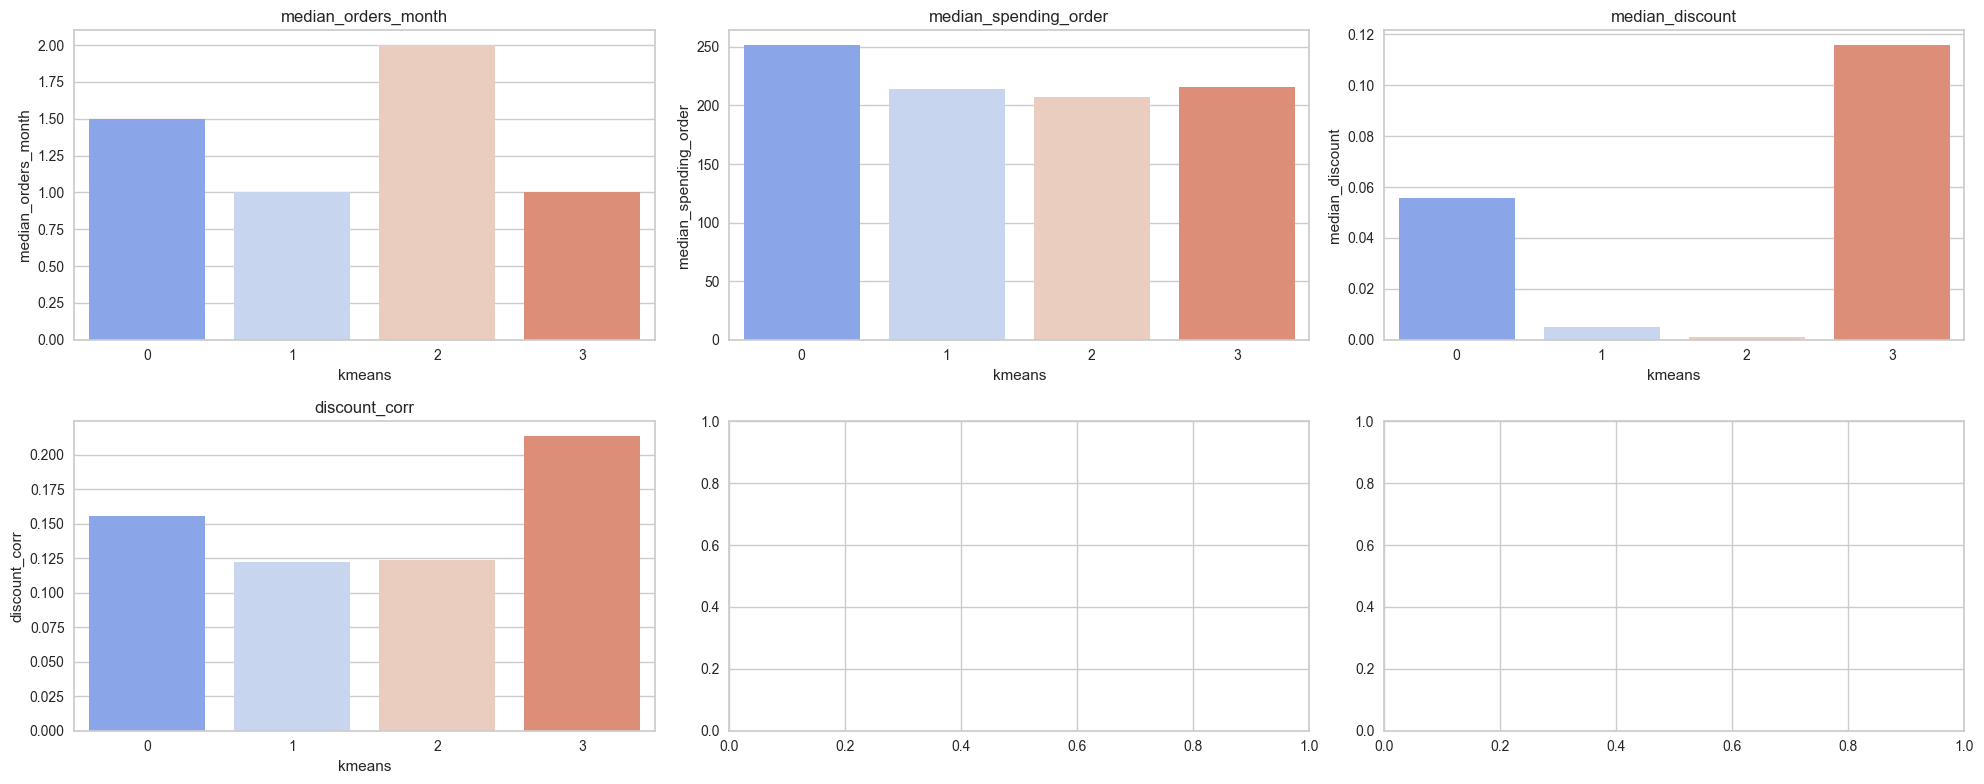

In [307]:
warnings.filterwarnings("ignore")
X_pca_v1 = X_pca_v1.astype("float")
clusterizador_v1 = sc.Clustering(X_pca_v1)

# 
clusterizador_v1.preparar_dataframe(scaler="robust")

customer_aggregated_v1_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,4)

sns.pairplot(customer_aggregated_v1_clustered, hue="clusters_kmeans")

clusterizador_v1.plot_clusters("kmeans",customer_aggregated_v1_outliers)
warnings.filterwarnings("default")

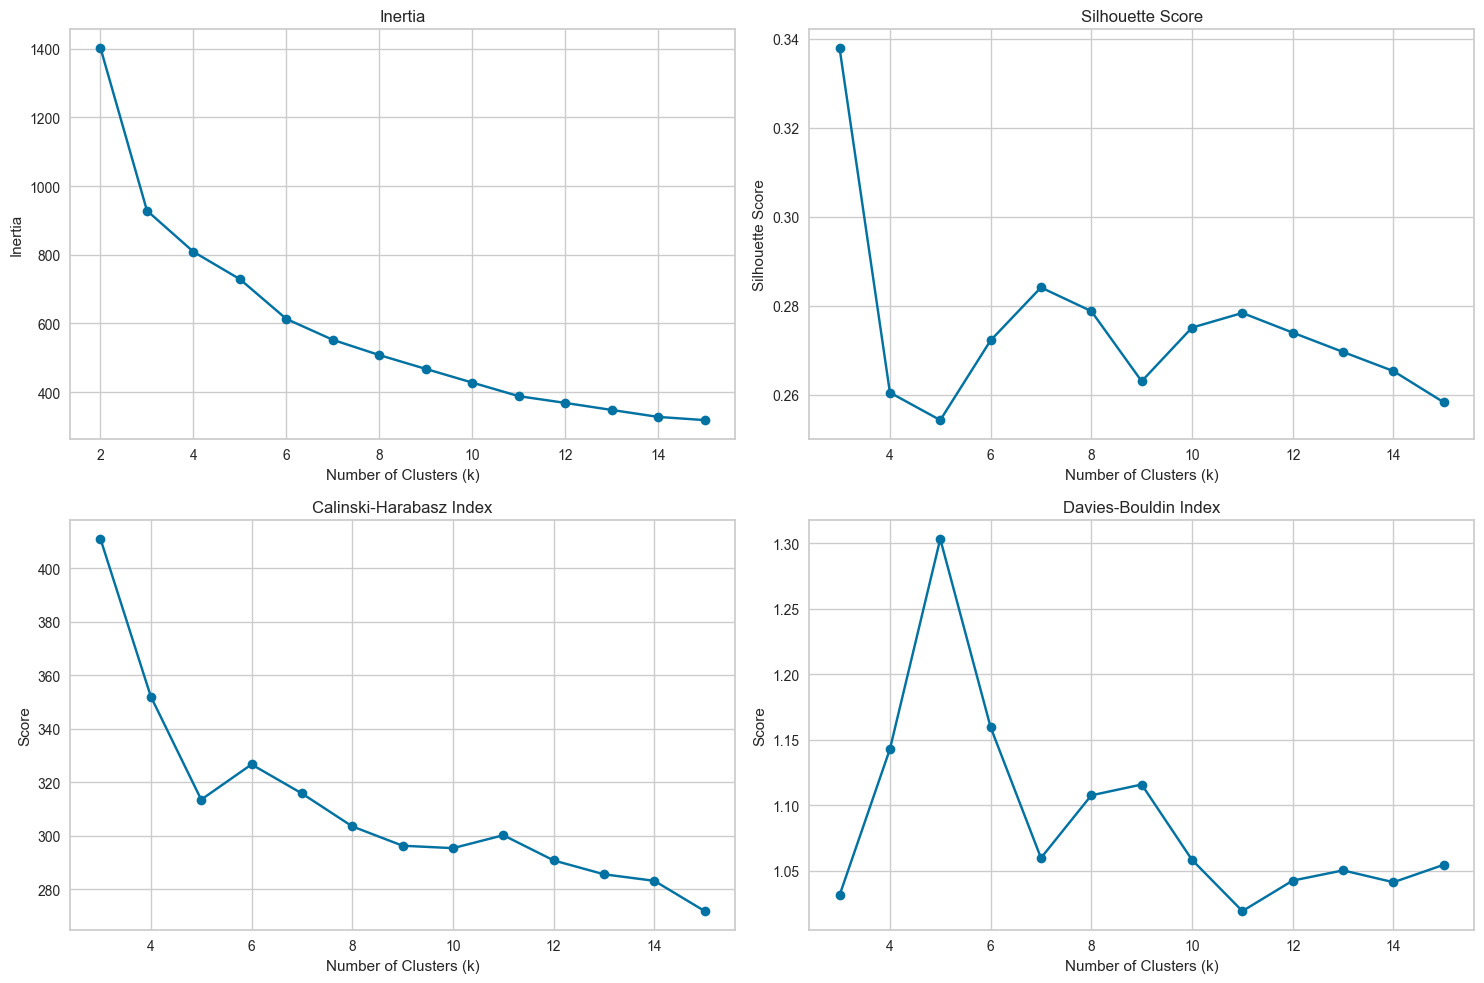

In [110]:
choose_kmeans_k(X_pca_v2.iloc[:,:3])

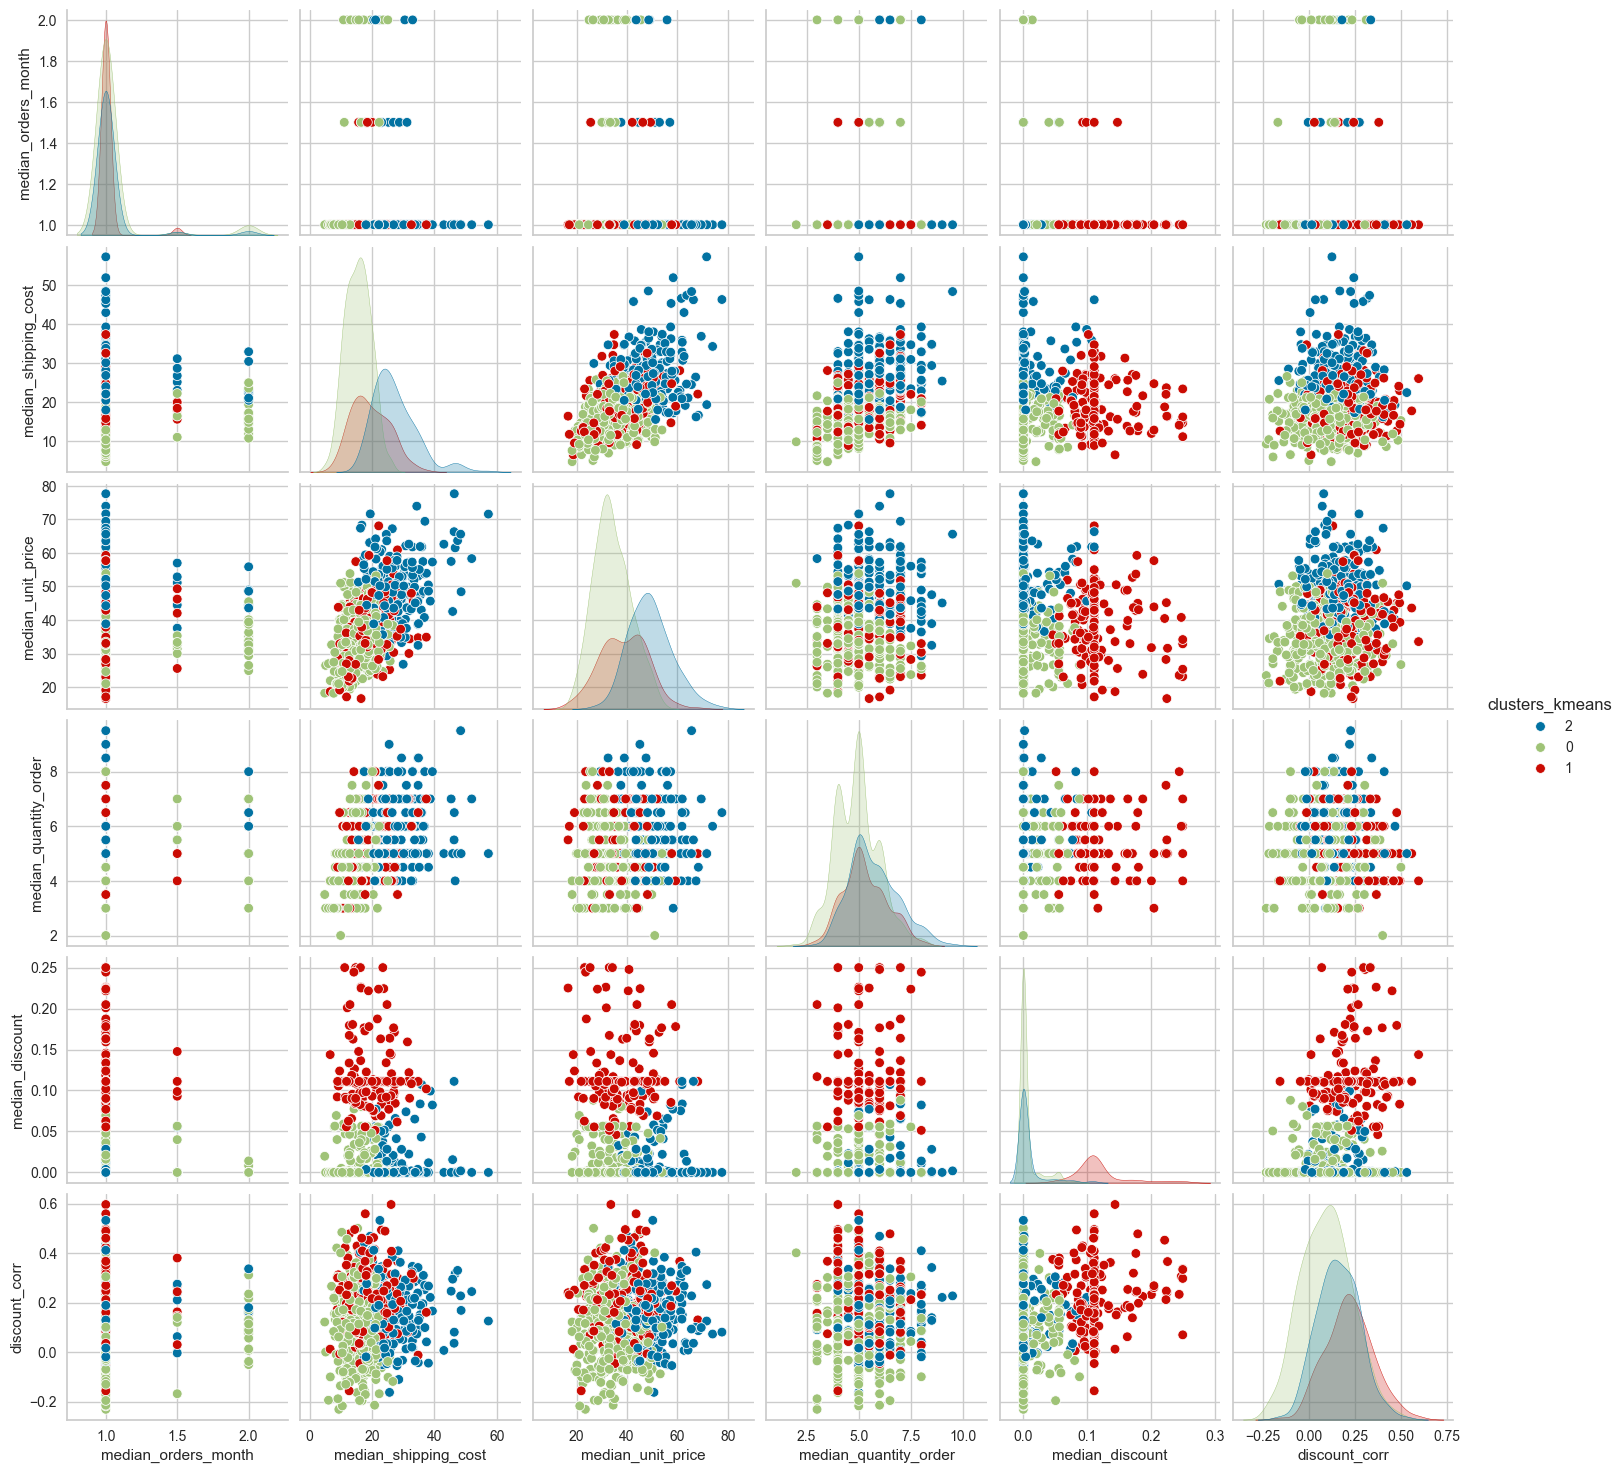

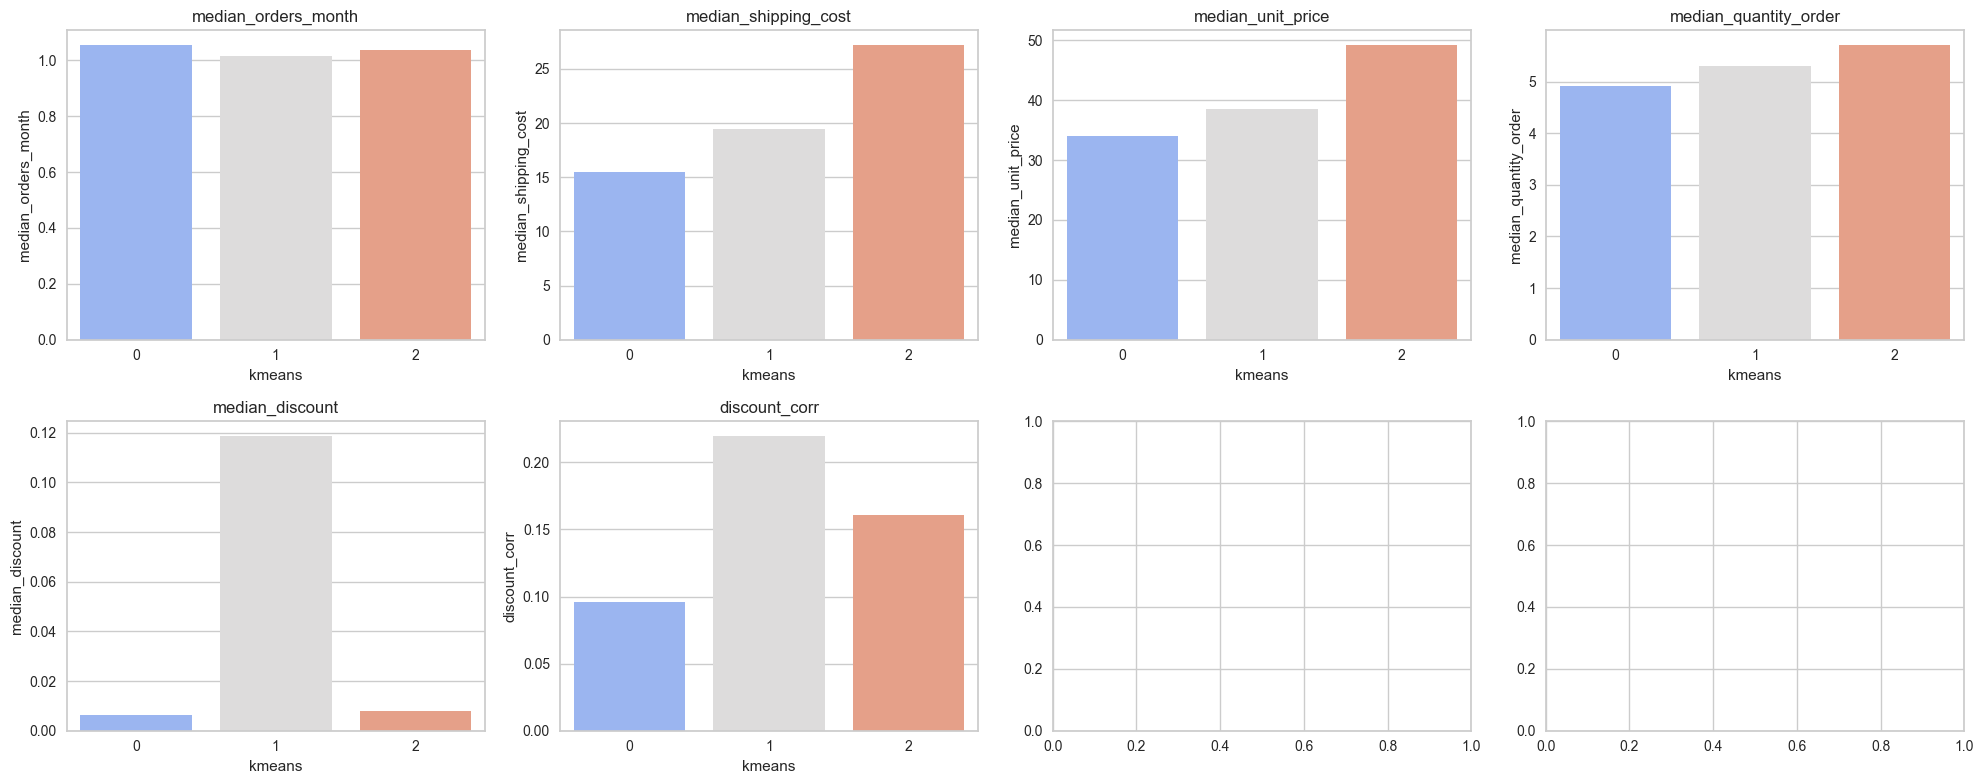

In [114]:
warnings.filterwarnings("ignore")
X_pca_v2.iloc[:,:3] = X_pca_v2.iloc[:,:3].astype("float")
clusterizador_v2 = sc.Clustering(X_pca_v2.iloc[:,:3])

# 
clusterizador_v2.preparar_dataframe(scaler="robust")

customer_aggregated_v2_clustered = clusterizador_v2.modelo_kmeans(customer_aggregated_v2_outliers,3)

sns.pairplot(customer_aggregated_v2_clustered, hue="clusters_kmeans")

clusterizador_v2.plot_clusters("kmeans",customer_aggregated_v2_outliers)
warnings.filterwarnings("default")

PCA does not help make more separable clusters. Although in the PCA space representation clusters are more separable, it seems like assigning them back to the original dataset did not bring better results.